# Desafio Titanic

    Procedimentos a serem feitos

- Testa algum modelo de probabilidades, ao invés de classificação binária

### Bibliotecas gerais

In [1]:
# Carregamento das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna

from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Carregamento do banco de dados (dependente dos arquivos parquet, se não tiver basta rodar o script inteiro uma primeira vez)
dados = pd.read_parquet('./dados/dados.parquet')
dados_full = pd.read_parquet('./dados/dados_sem_ohe.parquet')

### União treino/teste para análise conjunta de NaNs

In [ ]:
# Importação dos datasets
#treino = pd.read_csv("./dados/train.csv")
#teste = pd.read_csv("./dados/test.csv")

In [ ]:
treino['origem'] = 'treino'
teste['origem'] = 'teste'
dados = pd.concat([treino, teste], axis = 0)

### Verificação dos NaNs e imputação dos dados faltantes (se -in-existentes)

In [ ]:
# Verificando a existência de NaNs
dados.isnull().sum()

In [ ]:
# NaNs de 'Cabin': preenchendo com 'U' ('unknown')
dados['Cabin'] = dados['Cabin'].fillna('U')

In [ ]:
# NaNs de 'Embarked'
print("Proporções de embarques dos passageiros em relação às cidades de embarque:\n")
print(dados['Embarked'].value_counts(normalize = True)) # baseado só nas proporções, muito provavelmente os NaNs embarcaram em Southampton
print('\nEstatística descritiva dos valores pagos pela passagem ("Fare") em relação a cada uma\ndas cidades de embarque:\n')
print(dados.groupby(['origem', 'Embarked'])['Fare'].describe()) # baseado nos quartis do valor das tarifas, mais provável que tenha embarcado em Cherbourg. Utilizada esta premissa.
dados['Embarked'] = dados['Embarked'].fillna('C')

In [ ]:
# NaN de 'Fare' (dataset de teste)
dados[(dados['origem'] == 'teste') & dados['Fare'].isnull()]

# Passageiro embarcou em Southampton. Será que a tarifa tem alguma correlação com a idade?
dados[['Age', 'Fare']].corr()

# Como as duas variáveis praticamente não tem correlação, utilio a mediana das tarifas de Southampton para imputar o valor
dados.loc[dados['Fare'].isnull(), 'Fare'] = dados[dados['Embarked'] == 'S'].Fare.median()

In [ ]:
# NaNs de 'Age'
dados[dados['Age'].isnull()]

# São 263 observações sem registro de idade no total. Será tratado com imputação por algoritmo, mas para uma melhor assertividade nisso primeiro vou fazer o tratamento dos nomes dos passageiros.

### Manipulação dos dados

Trabalhando com os nomes e titulação

In [ ]:
# Obtenção dos sobrenomes
sobrenomes = dados['Name'].str.split(',').str.get(0)
sobrenomes = sobrenomes.str.strip()

# Obtenção dos títulos (Mr., Mrs., Miss., etc.)
resto_parcial = dados['Name'].str.split(',').str.get(1)
titulo = resto_parcial.str.split('.').str.get(0)
titulo = titulo.str.strip()

# Obtenção dos nomes
nomes = resto_parcial.str.split('.').str.get(1)
nomes_atuais = nomes.str.split('(').str.get(0)
nomes_atuais = nomes_atuais.str.strip()

# Obtenção dos nomes de solteira (quando aplicável)
solteira = nomes.str.split('(').str.get(1)
nome_solteira = solteira.str.split(')').str.get(0)
nome_solteira = nome_solteira.str.strip()

In [ ]:
# Cria um dataset temporário com os nomes manipulados
temp = pd.concat([titulo, nomes_atuais, sobrenomes, nome_solteira], axis = 1)
temp.columns = ('Title', 'Name', 'Surname', 'Single')
temp[["PassengerId", "Ticket"]] = dados[["PassengerId", "Ticket"]]
temp.reset_index(col_level = 'PassengerId', inplace = True)
temp.drop('index', axis = 1, inplace = True)

# Alguns nomes não seguiam o mesmo padrão de registro, acabaram dando problema (ficando vazios), o ajuste se dá com esse 'for' abaixo:
for i in temp.index:
    if temp.loc[i, 'Name'] == '':
        temp.loc[i, 'Name'] = temp.loc[i, 'Single']
    else: pass

# Abandona do registro o nome de solteira
temp.drop('Single', axis = 1, inplace = True)

Criação de variável indicativa de nobreza

In [ ]:
temp['Noblesse'] = np.nan
# Verificação de todos os títulos apresentados
temp.Title.value_counts()

São vários os títulos de nobreza apresentados na relação dos passageiros. A premissa é que em sendo considerado nobreza, portanto 'elite', o passageiro teria uma maior chance de sobrevivência.
- *Dr*: doutor, médico ou semelhante. Muito provavelmente fazia parte da elite (como seguidamente ainda o faz hoje em dia);
- *Sir*: título concedido pelo monarca da Inglaterra a alguns indivíduos de destaque da comunidade britânica em geral;
- *Mme*: *madame*, mulher pertencente à nobreza na França;
- *Don*/*Dona*: títulos de nobreza da Espanha (masc/fem);
- *Countess*: Condessa, grau de nobreza, esposa de um Conde;
- *Jonkheer*: escalão mais baixo da nobreza, mas nobre ainda assim.

Alguns títulos serão testados tanto como sendo nobreza e como sendo 'não-nobreza':
- *Col*: Coronel, alto escalão militar. Provavelmente é nobreza, mas em função da questão militar pode ter lutado para salvar a maior quantidade possível de passageiros do navio;
- *Major*: Mesmo raciocínio do Coronel;
- *Rev*: clérigo;
- *Capt*: Capitão, mesmo raciocínio dos outros militares.

In [ ]:
militar = ('Col', 'Major', 'Capt')
noblesse = ('Dr', 'Col', 'Major', 'Sir', 'Mme', 'Don', 'Capt', 'the Countess', 'Dona', 'Jonkheer', 'Rev')
mask = temp.Title.isin(noblesse)
temp.loc[mask, 'Noblesse'] = 1
temp.Noblesse = temp.Noblesse.fillna(0)

In [ ]:
# Criação de grupos em função do número do ticket. Podem ser famílias, amigos ou qualquer outra afinidade.
tickets = pd.DataFrame(temp.Ticket.value_counts())

temp['Grouped'] = 1
tickets_individuais = tickets[tickets['count'] == 1].index
mask = temp['Ticket'].isin(tickets_individuais)
temp.loc[mask, 'Grouped'] = 0

# Abandona variável 'Ticket', que já foi utilizada
temp.drop('Ticket', axis = 1, inplace = True)

Adição das variáveis manipuladas no dataframe original

In [ ]:
dados.reset_index(inplace = True)
dados.drop(['index', 'Name'], axis = 1, inplace = True)
dados = pd.concat([dados, temp.drop('PassengerId', axis = 1)], axis = 1)

Ajuste da variável 'Sex' para dummy

In [ ]:
# Transformação da variável 'Sex' em dummy (masc = 1, fem = 0)
mask = dados['Sex'] == 'male'
dados.loc[mask, 'isMale'] = 1
dados.isMale = dados.isMale.fillna(0)
dados.drop('Sex', axis = 1, inplace = True)

Inclusão da variável de tamanho de família

In [ ]:
# O tamanho total do grupo familiar embarcado se dá pela quantidade de irmãos/cônjuges (SibSp) somada à quantidade de pais/filhos (Parch) adicionada de 1 (o próprio indivíduo)
dados['FamilyTotal'] = dados['SibSp'] + dados['Parch'] + 1

Preenchimento das cabines de acordo com os tickets. Parte-se do princípio que um mesmo número de ticket dá direito a uma mesma cabine (ou pelo menos à mesma classe de cabines)

In [ ]:
# Verifica quais tickets possuem mais de um registro
mask = dados.Ticket.duplicated(keep = False)
mask = dados.Cabin.loc[mask].value_counts() > 1

# Identifica as cabines 'reais' (desconsidera as unknown)
cabines = mask[mask == True].index
cabines = cabines.drop('U')

# A partir das cabines corretas, verifica os tickets correspondentes para poder fazer o caminho inverso
tickets = dados[dados.Cabin.isin(cabines)]['Ticket']
mask = dados.Ticket.isin(tickets)

# Com os tickets identificados, transforma-se a classificação 'unknown' para NaN, de modo a se preencher por ffill
mask_cabines = dados.Cabin == 'U'
dados.loc[mask_cabines, 'Cabin'] = np.nan

# Separa e ordena as observações por Ticket e Cabin, para que possa ser  utilizado o ffill, posteriormente retorna-se os valores 'U' às demais cabines que realmente não tem como identificar
dados.loc[mask, ['Ticket', 'Cabin']] = dados.loc[mask, ['Ticket', 'Cabin']].sort_values(['Ticket', 'Cabin']).ffill()
dados.Cabin = dados.Cabin.fillna('U')

Uma vez que as cabines já estão bem ajustadas com referência aos tickets, manter-se-ão apenas as classes das cabines (A, B, C, etc), dispensando-se os números de identificação

In [ ]:
dados.Cabin = dados.Cabin.str.slice(stop = 1)

Visualização da matriz de correlações antes de OHE

In [ ]:
corr = dados.select_dtypes(exclude = 'object').corr()
corr.style.background_gradient(cmap='coolwarm')

OHE

Precisa das dummies para a imputação das idades também, então realizando OHE antes.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Cria um backup antes de OHE e imputações
dados_hist = dados.copy()

# Remoção de 'Embarked' e 'Ticket' pois não tem impacto na classificação
# Remoção de 'SibSp' e 'Parch' pela alta correlação de ambos com 'FamilyTotal'
dados.drop(['Embarked', 'Ticket', 'SibSp', 'Parch'], axis = 1, inplace = True)

# Define as variáveis a passarem por OHE e separa elas em um novo dataframe
colunas_ohe = ['Pclass', 'Cabin', 'Title']
temp_ohe = dados[colunas_ohe].copy()

# Chama o OHE e já realiza o processo
ohe = OneHotEncoder(categories = 'auto', drop = "first", sparse_output = False).set_output(transform = 'pandas')
categ_ohe = ohe.fit_transform(temp_ohe)

# Apaga as colunas originais do banco de dados
dados.drop(colunas_ohe, axis = 1, inplace = True)

# Concatena ambos datasets
dados = pd.concat([dados, categ_ohe], axis = 1)

# Já apaga nome e sobrenome, que não tem mais utilidade
dados.drop(['Name', 'Surname'], axis = 1, inplace = True)


Imputando as idades

In [ ]:
# Caso precise verificar a qualidade das imputações basta descomentar a linha abaixo
#idades_imputadas = dados.Age.isnull()

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Dropando o target (não é para imputar) e também origem (não interfere)
dados.drop(['Survived', 'origem'], axis = 1, inplace = True)

# Ajustes do imputer
imputer = IterativeImputer(max_iter=100,
                           tol=0.001,
                           initial_strategy='mean',
                           skip_complete=False,
                           min_value=0.33,
                           verbose=1,
                           random_state=1,
                           add_indicator=False,
                           keep_empty_features=False)

# A imputação propriamente dita gera um array, então já direcionando para um dataframe
dados_imputados = pd.DataFrame(imputer.fit_transform(dados))

# A imputação zera o nome das colunas, recuperando.
dados_imputados.columns = dados.columns

# Armazena as idades imputadas no dataset histórico (completo, sem OHE)
dados_hist.Age = dados_imputados.Age

# Repassando as idades imputadas no dataset de trabaho e retornando as colunas Survived e origem
dados.Age = dados_imputados.Age
dados[['Survived', 'origem']] = dados_hist[['Survived', 'origem']]


Verificação de outliers através de gráfico

In [ ]:
# Gráfico boxplot da variável 'Fare', possível outliers
plt.figure(figsize =(10, 8))
sns.boxplot(data = dados[dados['origem'] == 'treino'].Fare,
            saturation = 0.8,
            fill = False,
            width = 0.3,
            gap = 0.3,
            whis = 1.5, # interquartis
            linecolor = 'auto',
            linewidth = 1,
            fliersize = None,
            native_scale = False)
plt.title("Boxplot da variável 'Fare'", loc="center", fontsize=14)
plt.xlabel("Fare")
plt.ylabel("Valores")
plt.show()

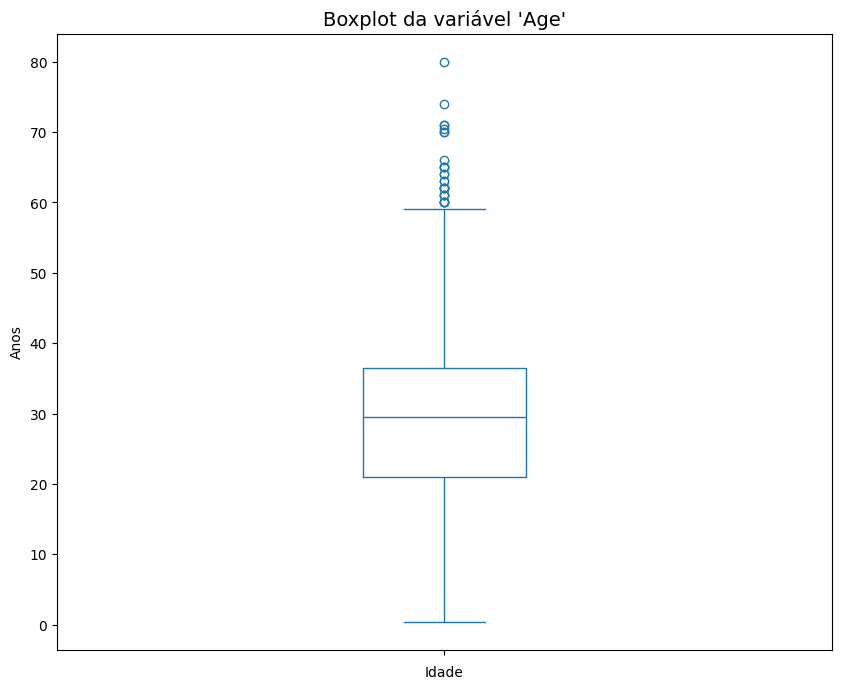

In [370]:
# Gráfico boxplot da variável 'Fare', possível outliers
plt.figure(figsize =(10, 8))
sns.boxplot(data = dados[dados['origem'] == 'treino'].Age,
            saturation = 0.8,
            fill = False,
            width = 0.3,
            gap = 0.3,
            whis = 1.5, # interquartis
            linecolor = 'auto',
            linewidth = 1,
            fliersize = None,
            native_scale = False)
plt.title("Boxplot da variável 'Age'", loc="center", fontsize=14)
plt.xlabel("Idade")
plt.ylabel("Anos")
plt.show()

Como a visualização não apresenta outliers inferiores, serão tratados apenas os valores superiores.

In [2]:
# Realização de ajuste dos outliers através das amplitudes interquartis

# Cálculo das amplitudes interquartis (IQR)
q1_fare = np.percentile(dados[dados['origem'] == 'treino'].Fare, 25)
q3_fare = np.percentile(dados[dados['origem'] == 'treino'].Fare, 75)
iqr_fare = q3_fare - q1_fare

q1_age = np.percentile(dados[dados['origem'] == 'treino'].Age, 25)
q3_age = np.percentile(dados[dados['origem'] == 'treino'].Age, 75)
iqr_age = q3_age - q1_age

# Cálculo do limite superior para ambas
outliers_fare_sup = q3_fare + 1.5 * iqr_fare
outliers_age_sup = q3_age + 1.5 * iqr_age

# Cria uma máscara (idx_outliers) para dropar as observações com outliers, caso necessário
mask = dados[dados['origem'] == 'treino'].index
mask = (dados.loc[mask, 'Fare'] >= outliers_fare_sup) | (dados.loc[mask, 'Age'] >= outliers_age_sup)
idx_outliers = dados[dados['origem'] == 'treino'].loc[mask].index


## Procedimentos pós-processamento original

In [160]:
temp = dados_full.copy()
temp['Noblesse'] = np.nan
militar = ('Col', 'Major', 'Capt')
indeciso = ('Sir', 'Don', 'Dona', 'Rev')
noblesse = ('Mme', 'the Countess', 'Jonkheer', 'Dr')
mask_nob = temp.Title.isin(noblesse)
mask_mil = temp.Title.isin(militar)
mask_ind = temp.Title.isin(indeciso)
temp.loc[mask_nob, 'Noblesse'] = 1
#temp.loc[mask_ind, 'Noblesse'] = 1
temp.loc[mask_mil, 'Noblesse'] = 1
temp.Noblesse = temp.Noblesse.fillna(0)
temp_nob_mil = temp

In [161]:
from sklearn.preprocessing import OneHotEncoder

# Remoção de 'Embarked' e 'Ticket' pois não tem impacto na classificação
# Remoção de 'SibSp' e 'Parch' pela alta correlação de ambos com 'FamilyTotal'
temp_nob_mil.drop(['Embarked', 'Ticket', 'SibSp', 'Parch'], axis = 1, inplace = True)

# Define as variáveis a passarem por OHE e separa elas em um novo dataframe
colunas_ohe = ['Pclass', 'Cabin', 'Title']
temp_ohe = temp_nob_mil[colunas_ohe].copy()

# Chama o OHE e já realiza o processo
ohe = OneHotEncoder(categories = 'auto', drop = "first", sparse_output = False).set_output(transform = 'pandas')
categ_ohe = ohe.fit_transform(temp_ohe)

# Apaga as colunas originais do banco de dados
temp_nob_mil.drop(colunas_ohe, axis = 1, inplace = True)

# Concatena ambos datasets
temp_nob_mil = pd.concat([temp_nob_mil, categ_ohe], axis = 1)

# Já apaga nome e sobrenome, que não tem mais utilidade
temp_nob_mil.drop(['Name', 'Surname', 'Sex'], axis = 1, inplace = True)

# Copia o banco de dados em questão para o objeto que será utilizado nas análises
dados = temp_nob_mil.copy()
dados.drop(['FamilyTotal', 'Grouped'], axis = 1, inplace = True)


    Separação em grupos de acordo com o total da família
- Grupo 1: FamilyTotal = 1, 2 ou 3 (corr 0,235 com Survived)
- Grupo 2: FamilyTotal = 4, 5 ou 6 (corr -0,534 com Survived)
- Grupo 3: FamilyTotal = 7, 8 ou 11 (corr -0,350 com Survived)

In [162]:
mask_grupo1 = dados_full[(dados_full.FamilyTotal == 1) | (dados_full.FamilyTotal == 2) | (dados_full.FamilyTotal == 3)].index
mask_grupo2 = dados_full[(dados_full.FamilyTotal == 4) | (dados_full.FamilyTotal == 5) | (dados_full.FamilyTotal == 6)].index
mask_grupo3 = dados_full[(dados_full.FamilyTotal == 7) | (dados_full.FamilyTotal == 8) | (dados_full.FamilyTotal == 11)].index

dados_full['Grupo1'] = 0
dados_full['Grupo2'] = 0
dados_full['Grupo3'] = 0

dados_full.loc[mask_grupo1, 'Grupo1'] = 1
dados_full.loc[mask_grupo2, 'Grupo2'] = 1
dados_full.loc[mask_grupo3, 'Grupo3'] = 1

# Modelagem

## Preparação dos dados

In [163]:
treino = dados[dados['origem'] == 'treino'].copy()
treino.drop(['origem', 'PassengerId'], inplace = True, axis = 1)
valid = dados[dados['origem'] == 'teste'].copy()
valid.drop(['origem', 'Survived', 'PassengerId'], inplace = True, axis = 1)

# O dataset acima é 'completo', ou seja, com outliers. Abaixo tem a exclusão dos outliers (Age e Fare)
# Realização de ajuste dos outliers através das amplitudes interquartis

# Cálculo das amplitudes interquartis (IQR)
q1_fare = np.percentile(dados[dados['origem'] == 'treino'].Fare, 25)
q3_fare = np.percentile(dados[dados['origem'] == 'treino'].Fare, 75)
iqr_fare = q3_fare - q1_fare

q1_age = np.percentile(dados[dados['origem'] == 'treino'].Age, 25)
q3_age = np.percentile(dados[dados['origem'] == 'treino'].Age, 75)
iqr_age = q3_age - q1_age

# Cálculo do limite superior para ambas
outliers_fare_sup = q3_fare + 1.5 * iqr_fare
outliers_age_sup = q3_age + 1.5 * iqr_age

# Cria uma máscara (idx_outliers) para dropar as observações com outliers, caso necessário
mask = dados[dados['origem'] == 'treino'].index
mask = (dados.loc[mask, 'Fare'] >= outliers_fare_sup) | (dados.loc[mask, 'Age'] >= outliers_age_sup)
idx_outliers = dados[dados['origem'] == 'treino'].loc[mask].index
treino.drop(idx_outliers, axis = 0, inplace = True)

# Definição das variáveis independente e dependentes
target = ['Survived']
dados_treino = treino.drop(target, axis = 1)
teste = treino[target]
tamanho_treino = 0.8

# Separação das observações para modelagem, entre observações de treino e de teste
treino_x, teste_x, treino_y, teste_y = train_test_split(dados_treino, teste, train_size = tamanho_treino, random_state = 1)

In [164]:
# Escrevendo algumas funções que eu utilizo por verbosidade durante a realização das modelagens

# Informações sobre outliers
def verif_outliers():
    if treino.Fare.max() > 300: print("Outliers em 'Fare' identificados.\n")
    else: print("Não foram identificados outliers (somente 'Fare' é passível de ter outliers).\n")

In [165]:
# Matriz de correlação já com OHE
#corr = treino.select_dtypes(exclude = 'object').corr()
#corr.style.background_gradient(cmap='coolwarm')

## XGBoost

### Modelo

In [166]:
import xgboost as xgb

# Estabelecimento do nome do modelo para fins de registro
nome_modelo = datetime.now().strftime("%Y%m%d-%H%M")

# O XGBClassifier precisa que todas as variáveis sejam categóricas

classif_xgb = xgb.XGBClassifier(booster = "gbtree", # gbtree, dart
                                tree_method = "approx", # hist, approx
                                n_estimators = 1366,
                                early_stopping_rounds = 500,
                                device="cuda",
                                nthread = 12,
                                eta = 0.037, #learning rate (0.0-1.0)
                                max_depth = 14, # default 1
                                max_leaves = 135,
                                objective = 'binary:logistic', # binary:logistic (retorna probabilidade), binary:logitraw (retorna score antes de transformação log), binary:hinge é o padrão
                                eval_metric = 'error', # utilizado em classificação binária
                                seed = 1)

verif_outliers()

classif_xgb.fit(treino_x, treino_y,
            eval_set = [(treino_x, treino_y), (teste_x, teste_y)],
            verbose = 0)

cv_scores_xgb_treino = cross_val_score(classif_xgb, treino_x, y = treino_y, # estimador (usado no fit), X, y (se existente)
                                       cv = 5, # None: default 5-fold cross validation
                                       n_jobs = 12,
                                       verbose = 0,
                                       params = {'eval_set':[(treino_x, treino_y), (teste_x, teste_y)], 'verbose':0}, 
                                       error_score = 'raise')
cv_scores_xgb_treino.mean()

discard_index = classif_xgb.feature_importances_ == 0
ypred_xgb = classif_xgb.predict(teste_x)
score_xgb_r2 = r2_score(teste_y, ypred_xgb)
print(f'\nCoeficiente de determinação: {score_xgb_r2:.6f}')
print(f'Score de validação cruzada: {cv_scores_xgb_treino.mean():.6f}')

# Verifica a existência de variáveis desprezíveis utilizadas na modelagem
if discard_index.sum() > 0:
    print("\nATENÇÃO! Variáveis sem importância encontradas!")
    print("\nPodem ser descartadas as variáveis: ", dados_treino.columns.values[discard_index])
else: print("\nTodas variáveis utilizadas, nenhuma sem importância.")

Não foram identificados outliers (somente 'Fare' é passível de ter outliers).



/home/thiago/.pyenv/versions/3.12.3/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [08:48:10] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/thiago/.pyenv/versions/3.12.3/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [08:48:10] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the devic


Coeficiente de determinação: 0.244160
Score de validação cruzada: 0.836143

ATENÇÃO! Variáveis sem importância encontradas!

Podem ser descartadas as variáveis:  ['Cabin_B' 'Cabin_F' 'Cabin_G' 'Cabin_T' 'Title_Col' 'Title_Don'
 'Title_Dona' 'Title_Dr' 'Title_Jonkheer' 'Title_Lady' 'Title_Major'
 'Title_Mlle' 'Title_Mme' 'Title_Ms' 'Title_Sir' 'Title_the Countess']


/home/thiago/.pyenv/versions/3.12.3/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [08:48:11] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/thiago/.pyenv/versions/3.12.3/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [08:48:11] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the devic

### Optuna

In [167]:
"""
# Define a função que vai testar os hiperparâmetros
def objective(testar):
    tree_method = testar.suggest_categorical('three_method', ['approx', 'hist'])
    n_estimators = testar.suggest_int('n_estimators', 500, 2500)
    eta = testar.suggest_float('eta', 0.001, 0.050, step = 0.001)
    max_depth = testar.suggest_int('max_depth', 1, 100)
    max_leaves = testar.suggest_int('max_leaves', 10, 1000, step = 25)
    objective = testar.suggest_categorical('objective', ['binary:logistic', 'binary:hinge'])

    classif_xgb = xgb.XGBClassifier(booster = "gbtree",
                                tree_method = tree_method,
                                n_estimators = n_estimators,
                                early_stopping_rounds = 500,
                                device="cuda",
                                nthread = 12,
                                eta = eta,
                                max_depth = max_depth,
                                max_leaves = max_leaves,
                                objective = objective,
                                eval_metric = 'error',
                                seed = 1)
    
    classif_xgb.fit(treino_x, treino_y,
            eval_set = [(treino_x, treino_y), (teste_x, teste_y)],
            verbose = 0)

    cv_scores_xgb_treino = cross_val_score(classif_xgb, treino_x, y = treino_y,
                                       cv = 5,
                                       n_jobs = 12,
                                       verbose = 0,
                                       params = {'eval_set':[(treino_x, treino_y), (teste_x, teste_y)], 'verbose':0}, 
                                       error_score = 'raise')
    
    return cv_scores_xgb_treino.mean()

# Cria o objeto de estudo dos parâmetros
optuna_xgb = optuna.create_study(direction = 'maximize',
                                 sampler = optuna.samplers.RandomSampler(seed = 1))

# Começa a realizar os testes de iteração
warnings.filterwarnings("ignore") # inibe os avisos dessa seção, volta ao normal no fim
optuna_xgb.optimize(objective, n_trials= 200)
warnings.filterwarnings("default")

# Armazena os melhores parâmetros em um objeto
melhores_optuna_xgb = optuna_xgb.best_params
print(melhores_optuna_xgb)
"""

'\n# Define a função que vai testar os hiperparâmetros\ndef objective(testar):\n    tree_method = testar.suggest_categorical(\'three_method\', [\'approx\', \'hist\'])\n    n_estimators = testar.suggest_int(\'n_estimators\', 500, 2500)\n    eta = testar.suggest_float(\'eta\', 0.001, 0.050, step = 0.001)\n    max_depth = testar.suggest_int(\'max_depth\', 1, 100)\n    max_leaves = testar.suggest_int(\'max_leaves\', 10, 1000, step = 25)\n    objective = testar.suggest_categorical(\'objective\', [\'binary:logistic\', \'binary:hinge\'])\n\n    classif_xgb = xgb.XGBClassifier(booster = "gbtree",\n                                tree_method = tree_method,\n                                n_estimators = n_estimators,\n                                early_stopping_rounds = 500,\n                                device="cuda",\n                                nthread = 12,\n                                eta = eta,\n                                max_depth = max_depth,\n                        

In [168]:
"""
# Gráficos diversos sobre o estudo realizado
optuna.visualization.plot_optimization_history(optuna_xgb)

#optuna.visualization.plot_param_importances(optuna_xgb)

#optuna.visualization.plot_parallel_coordinate(optuna_xgb)

#optuna.visualization.plot_slice(optuna_xgb,  params = ['n_estimators',
#                                                  'eta',
#                                                  'max_depth',
#                                                  'max_leaves'])
"""

"\n# Gráficos diversos sobre o estudo realizado\noptuna.visualization.plot_optimization_history(optuna_xgb)\n\n#optuna.visualization.plot_param_importances(optuna_xgb)\n\n#optuna.visualization.plot_parallel_coordinate(optuna_xgb)\n\n#optuna.visualization.plot_slice(optuna_xgb,  params = ['n_estimators',\n#                                                  'eta',\n#                                                  'max_depth',\n#                                                  'max_leaves'])\n"

In [169]:
"""
# Realiza o registro em arquivo texto para posterior consulta
with open("./registros/optuna_xgbclassifier.txt", "a") as registros:
    registros.write("########## INÍCIO DE REGISTRO OPTUNA - MODELO XGBoostClassifier ##########\n")
    registros.write("\nInformações armazenadas em " + datetime.now().strftime("%d-%m-%Y") + " às " + datetime.now().strftime("%H:%M") + ".\n")
    
    registros.write('\n---===+++ Os melhores parâmetros encontrados +++===---\n\n')
    registros.write(str(melhores_optuna_xgb))
    registros.write(f'\n\nObtidos na iteração {optuna_xgb.best_trial.number}\n')
    registros.write(f'Valor de score cross-validation {optuna_xgb.best_value}\n\n')
    registros.write("########## FINAL DE REGISTRO OPTUNA - MODELO XGBoostClassifier ##########\n\n\n")
"""

'\n# Realiza o registro em arquivo texto para posterior consulta\nwith open("./registros/optuna_xgbclassifier.txt", "a") as registros:\n    registros.write("########## INÍCIO DE REGISTRO OPTUNA - MODELO XGBoostClassifier ##########\n")\n    registros.write("\nInformações armazenadas em " + datetime.now().strftime("%d-%m-%Y") + " às " + datetime.now().strftime("%H:%M") + ".\n")\n    \n    registros.write(\'\n---===+++ Os melhores parâmetros encontrados +++===---\n\n\')\n    registros.write(str(melhores_optuna_xgb))\n    registros.write(f\'\n\nObtidos na iteração {optuna_xgb.best_trial.number}\n\')\n    registros.write(f\'Valor de score cross-validation {optuna_xgb.best_value}\n\n\')\n    registros.write("########## FINAL DE REGISTRO OPTUNA - MODELO XGBoostClassifier ##########\n\n\n")\n'

### Previsão do modelo e geração do arquivo de submissão

###### MODELO XGBoost 20240704-0847 ######

Informações geradas em 04-07-2024 às 08:48.

Coeficiente de Determinação R2: 0.244160
Score de validação cruzada: 0.836143

---===+++ Predicted and historical ranking comparison +++===---

Survived/perished relationship in TRAINING data:
                     PClass1        PClass2        Pclass3
Male/Survived...:  36.885246%     15.740741%     13.544669%
Male/Perished...:  63.114754%     84.259259%     86.455331%
                        *              *              *
Female/Survived.:  96.808511%     92.105263%     50.000000%
Female/Perished.:  03.191489%     07.894737%     50.000000%


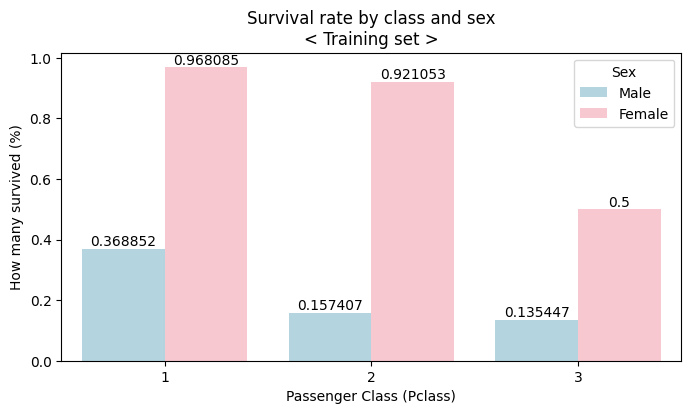

Survived/perished relationship in PREDICTED data:
                     PClass1        PClass2        Pclass3
Male/Survived...:  47.368421%     07.936508%     08.219178%
Male/Perished...:  52.631579%     92.063492%     91.780822%
                        *              *              *
Female/Survived.:  100.000000%     100.000000%     37.500000%
Female/Perished.:  00.000000%     00.000000%     62.500000%


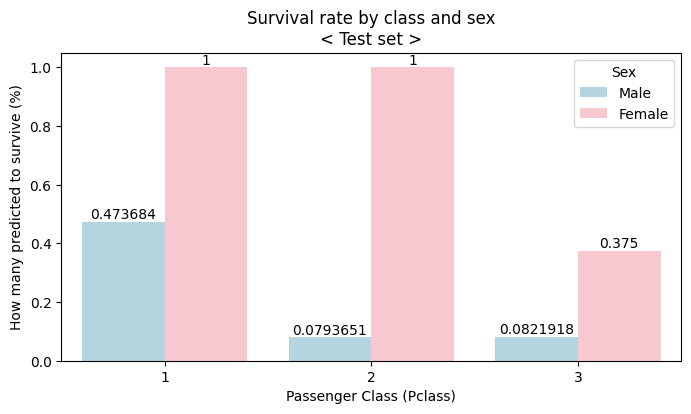


Features que foram utilizadas no modelo e que tiveram relevância no algoritmo:
        variável  importância
31     Title_Rev     0.361344
28      Title_Mr     0.255119
2       Noblesse     0.136897
8       Pclass_3     0.035744
11       Cabin_D     0.033610
5         Grupo2     0.021590
16       Cabin_U     0.021161
25    Title_Miss     0.019465
12       Cabin_E     0.019154
4         Grupo1     0.018321
3         isMale     0.017787
1           Fare     0.016682
10       Cabin_C     0.012376
0            Age     0.011847
7       Pclass_2     0.006701
29     Title_Mrs     0.005598
24  Title_Master     0.003997
6         Grupo3     0.002607

Features sem importância: ['Cabin_B' 'Cabin_F' 'Cabin_G' 'Cabin_T' 'Title_Col' 'Title_Don'
 'Title_Dona' 'Title_Dr' 'Title_Jonkheer' 'Title_Lady' 'Title_Major'
 'Title_Mlle' 'Title_Mme' 'Title_Ms' 'Title_Sir' 'Title_the Countess'] .

Coeficiente de Determinação R2: 0.244160
Score de validação cruzada: 0.836143

Não foram identificados outliers (so

In [170]:
warnings.filterwarnings("ignore") # inibe os avisos dessa seção, volta ao normal no fim

# A previsão propriamente dita
#valid_xgb = valid.drop(var_remove, axis = 1)
ypred_xgb_final = classif_xgb.predict(valid)

# Cálculos e procedimentos necessários anteriores às impressões em terminal ou arquivo
# Cópia do banco de dados antes de OHE (menos memória ocupada)
dados_xgb = dados_full.copy()
paleta = {"Male": "lightblue", "Female": "pink"}

# Impostação do resultado obtido
mask = dados_xgb['origem'] == 'teste'
dados_xgb.loc[mask, 'Survived'] = ypred_xgb_final

# A apresentação em terminal
print("###### MODELO XGBoost " + nome_modelo + " ######")
print("\nInformações geradas em " + datetime.now().strftime("%d-%m-%Y") + " às " + datetime.now().strftime("%H:%M") + ".\n")

print(f'Coeficiente de Determinação R2: {score_xgb_r2:.6f}')
print(f'Score de validação cruzada: {cv_scores_xgb_treino.mean():.6f}\n')

# Dos dados de Treino
print('---===+++ Predicted and historical ranking comparison +++===---\n')
print('Survived/perished relationship in TRAINING data:')

    # Máscaras
mask1 = dados_xgb[(dados_xgb['Pclass'] == 1) & (dados_xgb['origem'] == 'treino')].index
mask2 = dados_xgb[(dados_xgb['Pclass'] == 2) & (dados_xgb['origem'] == 'treino')].index
mask3 = dados_xgb[(dados_xgb['Pclass'] == 3) & (dados_xgb['origem'] == 'treino')].index
    
    # Relação de sobreviventes ou não da 1a classe
ms1 = (len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Male')])*100)
md1 = (len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Male')])*100)
fs1 = (len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Female')])*100)
fd1 = (len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Female')])*100)

    # Relação de sobreviventes ou não da 2a classe
ms2 = (len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Male')])*100)
md2 = (len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Male')])*100)
fs2 = (len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Female')])*100)
fd2 = (len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Female')])*100)

    # Relação de sobreviventes ou não da 3a classe
ms3 = (len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Male')])*100)
md3 = (len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Male')])*100)
fs3 = (len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Female')])*100)
fd3 = (len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Female')])*100)

print(f'                     PClass1        PClass2        Pclass3')
print(f'Male/Survived...:  {ms1:0>9f}%     {ms2:0>9f}%     {ms3:0>9f}%')
print(f'Male/Perished...:  {md1:0>9f}%     {md2:0>9f}%     {md3:0>9f}%')
print(f'                        *              *              *')
print(f'Female/Survived.:  {fs1:0>9f}%     {fs2:0>9f}%     {fs3:0>9f}%')
print(f'Female/Perished.:  {fd1:0>9f}%     {fd2:0>9f}%     {fd3:0>9f}%')

# Prints the train graph
plt.figure(figsize =(8, 4))
sns.color_palette("pastel")
grafico_treino = sns.barplot(data=dados_xgb[dados_xgb['origem'] == 'treino'], x='Pclass', y='Survived', hue = 'Sex', hue_order = ['Male', 'Female'], palette = paleta, errorbar = None)
grafico_treino.bar_label(grafico_treino.containers[0], fontsize=10)
grafico_treino.bar_label(grafico_treino.containers[1], fontsize=10)
plt.ylabel("How many survived (%)")
plt.xlabel('Passenger Class (Pclass)')
plt.title("Survival rate by class and sex\n< Training set >")
plt.show()


# Dos dados de teste
print('Survived/perished relationship in PREDICTED data:')

mask1 = dados_xgb[(dados_xgb['Pclass'] == 1) & (dados_xgb['origem'] == 'teste')].index
mask2 = dados_xgb[(dados_xgb['Pclass'] == 2) & (dados_xgb['origem'] == 'teste')].index
mask3 = dados_xgb[(dados_xgb['Pclass'] == 3) & (dados_xgb['origem'] == 'teste')].index
    
    # Relação de sobreviventes ou não da 1a classe
ms1 = (len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Male')])*100)
md1 = (len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Male')])*100)
fs1 = (len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Female')])*100)
fd1 = (len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Female')])*100)

    # Relação de sobreviventes ou não da 2a classe
ms2 = (len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Male')])*100)
md2 = (len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Male')])*100)
fs2 = (len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Female')])*100)
fd2 = (len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Female')])*100)

    # Relação de sobreviventes ou não da 3a classe
ms3 = (len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Male')])*100)
md3 = (len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Male')])*100)
fs3 = (len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Female')])*100)
fd3 = (len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Female')])*100)


print(f'                     PClass1        PClass2        Pclass3')
print(f'Male/Survived...:  {ms1:0>9f}%     {ms2:0>9f}%     {ms3:0>9f}%')
print(f'Male/Perished...:  {md1:0>9f}%     {md2:0>9f}%     {md3:0>9f}%')
print(f'                        *              *              *')
print(f'Female/Survived.:  {fs1:0>9f}%     {fs2:0>9f}%     {fs3:0>9f}%')
print(f'Female/Perished.:  {fd1:0>9f}%     {fd2:0>9f}%     {fd3:0>9f}%')

# Prints the test graph
plt.figure(figsize =(8, 4))
grafico_teste = sns.barplot(data=dados_xgb[dados_xgb['origem'] == 'teste'], x='Pclass', y='Survived', hue = 'Sex', hue_order = ['Male', 'Female'], palette = paleta, errorbar = None)
grafico_teste.bar_label(grafico_teste.containers[0], fontsize=10)
grafico_teste.bar_label(grafico_teste.containers[1], fontsize=10)
plt.ylabel("How many predicted to survive (%)")
plt.xlabel('Passenger Class (Pclass)')
plt.title("Survival rate by class and sex\n< Test set >")
plt.show()
warnings.filterwarnings("default")

print("\nFeatures que foram utilizadas no modelo e que tiveram relevância no algoritmo:")
importancias = pd.DataFrame(classif_xgb.feature_importances_, classif_xgb.feature_names_in_)
importancias.reset_index(inplace = True)
importancias.columns = ["variável", "importância"]
print(importancias[importancias['importância'] > 0].sort_values(by = "importância", ascending = False))
if discard_index.sum() > 0:
    print("\nFeatures sem importância:", dados_treino.columns.values[discard_index], ".\n")
else: print("\nNão foram identificadas features sem importância.\n")

print(f'Coeficiente de Determinação R2: {score_xgb_r2:.6f}')
print(f'Score de validação cruzada: {cv_scores_xgb_treino.mean():.6f}\n')

verif_outliers()

print("Parâmetros do modelo:")
print(classif_xgb.get_params())
print("\n=======================================================================")

Manipulação da última previsão realizada para submissão

In [171]:
print(f'Previsão em uso possui registro {nome_modelo}.')
print("Compilando nome de arquivo para submissão...")
# Composição do nome a ser salvo
ext_final = (".csv")
save_final = ("resultado_XGBClassifier_"+(nome_modelo + ext_final))

print("Gerando arquivo de submissão com nome " + save_final)
# Leitura do arquivo de submisão, registro dos dados obtidos e regravação do arquivo com estes dados
submissao = pd.read_csv("./dados/gender_submission.csv")
submissao["Survived"] = ypred_xgb_final
submissao.to_csv("./resultados/"+save_final, index=False)

print("\nProcedimento realizado com sucesso. O arquivo em questão encontra-se na pasta de destino ('./resultados/').")

Previsão em uso possui registro 20240704-0847.
Compilando nome de arquivo para submissão...
Gerando arquivo de submissão com nome resultado_XGBClassifier_20240704-0847.csv

Procedimento realizado com sucesso. O arquivo em questão encontra-se na pasta de destino ('./resultados/').


Confusion Matrix

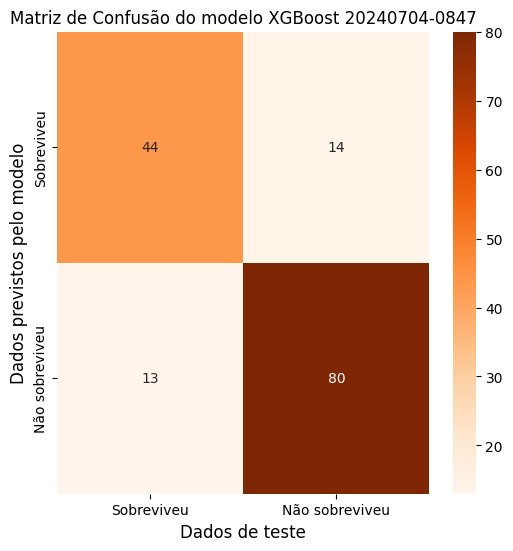

In [172]:
# O parâmetro 'labels' identifica as classificações dentro das variáveis, a primeira sendo a variável positiva e a segunda, a negativa
# Pela lógica, positiva aqui significa 'sobrevivente'.

conf_matrix = metrics.confusion_matrix(teste_y.Survived.values.astype('int'), ypred_xgb, labels=[1, 0])

# Plotagem da matriz
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix,
            annot = True,
            cmap = 'Oranges',
            xticklabels = ['Sobreviveu', 'Não sobreviveu'],
            yticklabels = ['Sobreviveu', 'Não sobreviveu'])
plt.title(f'Matriz de Confusão do modelo XGBoost {nome_modelo}', fontsize=12)
plt.xlabel('Dados de teste', fontsize=12)
plt.ylabel('Dados previstos pelo modelo', fontsize=12)
plt.show()

### Registro para consulta

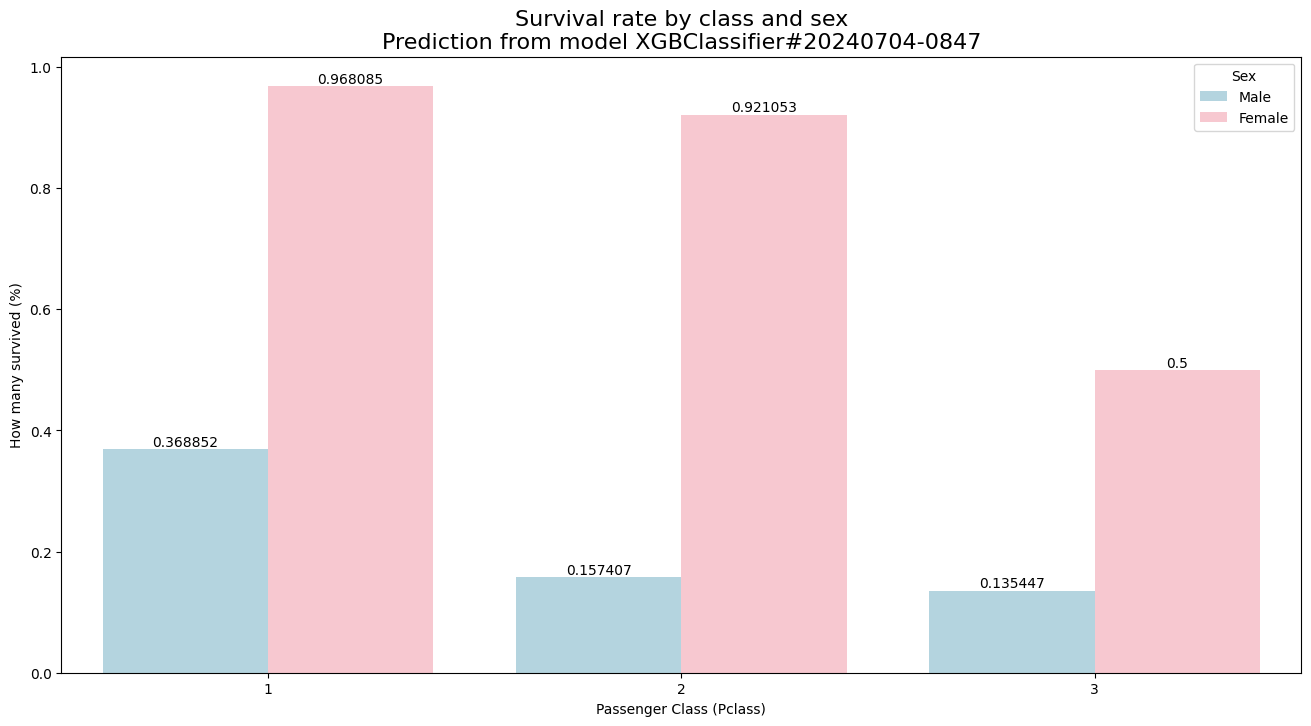

In [173]:
with open("./registros/registros_xgb.txt", "a") as registros:
    registros.write("########## INÍCIO DE REGISTRO - MODELO XGBoostClassifier " + nome_modelo + " ##########\n")
    registros.write("\nInformações geradas em " + datetime.now().strftime("%d-%m-%Y") + " às " + datetime.now().strftime("%H:%M") + ".\n")
    warnings.filterwarnings("ignore") # inibe os avisos dessa seção, volta ao normal no fim

    # Impostação do resultado obtido
    mask = dados_xgb['origem'] == 'teste'
    dados_xgb.loc[mask, 'Survived'] = ypred_xgb_final

    # Dos dados de Treino
    registros.write('\n---===+++ Predicted and historical ranking comparison +++===---\n')
    registros.write('\nSurvived/perished relationship in *TRAINING* data:\n')

        # Máscaras
    mask1 = dados_xgb[(dados_xgb['Pclass'] == 1) & (dados_xgb['origem'] == 'treino')].index
    mask2 = dados_xgb[(dados_xgb['Pclass'] == 2) & (dados_xgb['origem'] == 'treino')].index
    mask3 = dados_xgb[(dados_xgb['Pclass'] == 3) & (dados_xgb['origem'] == 'treino')].index
    
        # Relação de sobreviventes ou não da 1a classe
    ms1 = (len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Male')])*100)
    md1 = (len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Male')])*100)
    fs1 = (len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Female')])*100)
    fd1 = (len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Female')])*100)

        # Relação de sobreviventes ou não da 2a classe
    ms2 = (len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Male')])*100)
    md2 = (len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Male')])*100)
    fs2 = (len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Female')])*100)
    fd2 = (len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Female')])*100)

        # Relação de sobreviventes ou não da 3a classe
    ms3 = (len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Male')])*100)
    md3 = (len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Male')])*100)
    fs3 = (len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Female')])*100)
    fd3 = (len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Female')])*100)

    registros.write(f'                     PClass1        PClass2        Pclass3\n')
    registros.write(f'Male/Survived...:  {ms1:0>9f}%     {ms2:0>9f}%     {ms3:0>9f}%\n')
    registros.write(f'Male/Perished...:  {md1:0>9f}%     {md2:0>9f}%     {md3:0>9f}%\n')
    registros.write(f'                        *              *              *\n')
    registros.write(f'Female/Survived.:  {fs1:0>9f}%     {fs2:0>9f}%     {fs3:0>9f}%\n')
    registros.write(f'Female/Perished.:  {fd1:0>9f}%     {fd2:0>9f}%     {fd3:0>9f}%\n')

    # Das previsões
    registros.write('\nSurvived/perished relationship in *PREDICTED* data:\n')

    mask1 = dados_xgb[(dados_xgb['Pclass'] == 1) & (dados_xgb['origem'] == 'teste')].index
    mask2 = dados_xgb[(dados_xgb['Pclass'] == 2) & (dados_xgb['origem'] == 'teste')].index
    mask3 = dados_xgb[(dados_xgb['Pclass'] == 3) & (dados_xgb['origem'] == 'teste')].index

        # Relação de sobreviventes ou não da 1a classe
    ms1 = (len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Male')])*100)
    md1 = (len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Male')])*100)
    fs1 = (len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Female')])*100)
    fd1 = (len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask1][(dados_xgb['Sex'] == 'Female')])*100)

        # Relação de sobreviventes ou não da 2a classe
    ms2 = (len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Male')])*100)
    md2 = (len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Male')])*100)
    fs2 = (len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Female')])*100)
    fd2 = (len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask2][(dados_xgb['Sex'] == 'Female')])*100)

        # Relação de sobreviventes ou não da 3a classe
    ms3 = (len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Male')])*100)
    md3 = (len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Male') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Male')])*100)
    fs3 = (len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 1)]) / len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Female')])*100)
    fd3 = (len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Female') & (dados_xgb['Survived'] == 0)]) / len(dados_xgb.loc[mask3][(dados_xgb['Sex'] == 'Female')])*100)


    registros.write(f'                     PClass1        PClass2        Pclass3\n')
    registros.write(f'Male/Survived...:  {ms1:0>9f}%     {ms2:0>9f}%     {ms3:0>9f}%\n')
    registros.write(f'Male/Perished...:  {md1:0>9f}%     {md2:0>9f}%     {md3:0>9f}%\n')
    registros.write(f'                        *              *              *\n')
    registros.write(f'Female/Survived.:  {fs1:0>9f}%     {fs2:0>9f}%     {fs3:0>9f}%\n')
    registros.write(f'Female/Perished.:  {fd1:0>9f}%     {fd2:0>9f}%     {fd3:0>9f}%\n')

    # Prints the predictions graph
    ext_graph = (".png")
    name_graph = ("previsoes_XGBClassifier_"+(nome_modelo + ext_graph))
    plt.figure(figsize =(16, 8))
    sns.color_palette("pastel")
    graph = sns.barplot(data=dados_xgb[dados_xgb['origem'] == 'treino'], x='Pclass', y='Survived', hue = 'Sex', hue_order = ['Male', 'Female'], palette = paleta, errorbar = None)
    graph.bar_label(graph.containers[0], fontsize=10)
    graph.bar_label(graph.containers[1], fontsize=10)
    plt.ylabel("How many survived (%)")
    plt.xlabel('Passenger Class (Pclass)')
    plt.title(f'Survival rate by class and sex\nPrediction from model XGBClassifier#{nome_modelo}', fontsize = 16)
    fig = graph.get_figure()
    fig.savefig('./imagens/'+name_graph)

    registros.write("\nFeatures que foram utilizadas no modelo e que tiveram relevância no algoritmo:\n")
    importancias = pd.DataFrame(classif_xgb.feature_importances_, classif_xgb.feature_names_in_)
    importancias.reset_index(inplace = True)
    importancias.columns = ["variável", "importância"]
    registros.write(str(importancias[importancias['importância'] > 0].sort_values(by = "importância", ascending = False)))
    if discard_index.sum() > 0:
        registros.write("\n\nFeatures sem importância:"+ str(dados_treino.columns.values[discard_index]) + ".\n")
    else: registros.write("\n\nNão foram identificadas features sem importância.\n")

    registros.write(f'\nCoeficiente de Determinação R2: {score_xgb_r2:.6f}\n')
    registros.write(f'Score de validação cruzada: {cv_scores_xgb_treino.mean():.6f}\n\n')

    if dados_xgb.Fare.max() > 300: registros.write("Outliers em 'Fare' identificados.\n")
    else: registros.write("Não foram identificados outliers (somente 'Fare' é passível de ter outliers).\n")


    registros.write("\nParâmetros do modelo:\n")
    registros.write(str(classif_xgb.get_params()))
    registros.write("\n\n=======================================================================\n\n\n")

## CatBoost

### Modelo

In [174]:
from catboost import CatBoostClassifier

# Estabelecimento do nome do modelo para fins de registro
nome_modelo = datetime.now().strftime("%Y%m%d-%H%M")

classif_cat = CatBoostClassifier(loss_function='Logloss', # https://catboost.ai/en/docs/concepts/loss-functions-classification#usage-information
                                 eval_metric = 'Logloss', # Logloss, AUC, MAPE, Poisson, Precision, Accuracy, R2, MedianAbsoluteError, PairAccuracy, PrecisionAt https://catboost.ai/en/docs/references/custom-metric__supported-metrics
                                 iterations = 1000,
                                 learning_rate = 0.032,
                                 random_seed = 1,
                                 bootstrap_type = 'MVS', #Bayesian (log), Bernoulli (estocástica), MVS (variância), Poisson (distribuição Poisson)
                                 bagging_temperature = 7, # 0-1, se 0 todas as observações tem um peso igual, usa distribuição exponencial se o parãmetro for 1
                                 depth = 17,
                                 early_stopping_rounds = 500,
                                 thread_count = 12,
                                 task_type = 'CPU', # GPU/CPU, mas está dando erro na GPU, diz que fica sem memória.
                                 gpu_ram_part = 0.2,
                                 target_border = 0.45, # nível de corte para transformar de 0 para 1
                                 grow_policy = 'Lossguide', # Lossguide, Depthwise, SymmetricTree
                                 min_child_samples = 39, # default 1
                                 max_leaves = 20, # default 31, não aconselhável > 64
                                 boosting_type = 'Plain', # https://catboost.ai/en/docs/references/training-parameters/common#boosting_type
                                 score_function = 'L2' # L2, NewtonL2. Também Cosine ou NewtonCosine, que não podem ser usados com grow_policy = lossguide
                                 )

verif_outliers()

classif_cat.fit(treino_x, treino_y,
            eval_set = (teste_x, teste_y),
            verbose = 100)

ypred_cat = classif_cat.predict(teste_x)
score_cat_r2 = r2_score(teste_y, ypred_cat)

cv_scores_cat = cross_val_score(classif_cat, treino_x, y = treino_y, # estimador (usado no fit), X, y (se existente)
                                       cv = 5, # None: default 5-fold cross validation
                                       n_jobs = 12,
                                       verbose = 0,
                                       params = {'eval_set':(teste_x, teste_y), 'verbose':0}, 
                                       error_score = 'raise')


discard_index = classif_cat.feature_importances_ == 0
print(f'\nCoeficiente de determinação: {score_cat_r2:.6f}')
print(f'Score de validação cruzada: {cv_scores_cat.mean():.6f}')

# Verifica a existência de variáveis desprezíveis utilizadas na modelagem
if discard_index.sum() > 0:
    print("\nATENÇÃO! Variáveis sem importância encontradas!")
    print("\nPodem ser descartadas as variáveis: ", dados_treino.columns.values[discard_index])
else: print("\nTodas variáveis utilizadas, nenhuma sem importância.")

Não foram identificados outliers (somente 'Fare' é passível de ter outliers).

0:	learn: 0.6708643	test: 0.6733882	best: 0.6733882 (0)	total: 2.19ms	remaining: 2.19s
100:	learn: 0.3163691	test: 0.4649636	best: 0.4525391 (45)	total: 144ms	remaining: 1.28s
200:	learn: 0.2750733	test: 0.4884804	best: 0.4525391 (45)	total: 278ms	remaining: 1.1s
300:	learn: 0.1989448	test: 0.5177907	best: 0.4525391 (45)	total: 412ms	remaining: 957ms
400:	learn: 0.1407185	test: 0.5450627	best: 0.4525391 (45)	total: 553ms	remaining: 825ms
500:	learn: 0.1068332	test: 0.5802481	best: 0.4525391 (45)	total: 693ms	remaining: 690ms
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.4525390693
bestIteration = 45

Shrink model to first 46 iterations.

Coeficiente de determinação: 0.188172
Score de validação cruzada: 0.817920

ATENÇÃO! Variáveis sem importância encontradas!

Podem ser descartadas as variáveis:  ['Title_Dona' 'Title_Jonkheer' 'Title_Mlle' 'Title_Mme' 'Title_Ms'
 'Title_the Countess']


###  Optuna

In [175]:
"""
from catboost import CatBoostClassifier

# Define a função que vai testar os hiperparâmetros
def objective(testar):
    loss_function = testar.suggest_categorical('loss_function', ['Logloss', 'CrossEntropy'])
    iterations = testar.suggest_int('iterations', 500, 2500, step = 100)
    eval_metric = testar.suggest_categorical('eval_metric', ['Logloss', 'AUC', 'Precision', 'Accuracy'])
    learning_rate = testar.suggest_float('learning_rate', 0.001, 0.050, step = 0.001)
    bootstrap_type = testar.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS', 'Poisson'])
    bagging_temperature = testar.suggest_int('bagging_temperature', 0, 10)
    depth = testar.suggest_int('depth', 2, 30)
    target_border = testar.suggest_float('target_border', 0.3, 0.8, step = 0.05)
    min_child_samples = testar.suggest_int('min_child_samples', 1, 50, step = 2)
    max_leaves = testar.suggest_int('max_leaves', 12, 64, step = 4)
    grow_policy = testar.suggest_categorical('grow_policy', ['Lossguide', 'Depthwise', 'SymmetricTree'])
    score_function = testar.suggest_categorical('score_function', ['L2', 'NewtonL2'])

    classif_cat = CatBoostClassifier(loss_function = loss_function,
                                 eval_metric = eval_metric,
                                 iterations = iterations,
                                 learning_rate = learning_rate,
                                 random_seed = 1,
                                 bootstrap_type = 'Bayesian',
                                 bagging_temperature = bagging_temperature,
                                 depth = depth,
                                 early_stopping_rounds = 500,
                                 thread_count = 10,
                                 task_type = 'GPU',
                                 gpu_ram_part = 0.2,
                                 target_border = target_border,
                                 grow_policy = 'Lossguide',
                                 min_child_samples = min_child_samples,
                                 max_leaves = max_leaves,
                                 boosting_type = 'Plain', # https://catboost.ai/en/docs/references/training-parameters/common#boosting_type
                                 score_function = score_function
                                 )
    
    classif_cat.fit(treino_x, treino_y,
            eval_set = (teste_x, teste_y),
            verbose = 0)

    cv_scores_cat = cross_val_score(classif_cat, treino_x, y = treino_y,
                                       cv = 5,
                                       n_jobs = 10,
                                       verbose = 0,
                                       params = {'eval_set':(teste_x, teste_y), 'verbose':0}, 
                                       error_score = 'raise')
    
    return cv_scores_cat.mean()

# Cria o objeto de estudo dos parâmetros
optuna_cat = optuna.create_study(direction = 'maximize',
                                 sampler = optuna.samplers.RandomSampler(seed = 1))

# Começa a realizar os testes de iteração
warnings.filterwarnings("ignore") # inibe os avisos dessa seção, volta ao normal no fim
optuna_cat.optimize(objective, n_trials= 200)
warnings.filterwarnings("default")

# Armazena os melhores parâmetros em um objeto
melhores_optuna_cat = optuna_cat.best_params
"""

'\nfrom catboost import CatBoostClassifier\n\n# Define a função que vai testar os hiperparâmetros\ndef objective(testar):\n    loss_function = testar.suggest_categorical(\'loss_function\', [\'Logloss\', \'CrossEntropy\'])\n    iterations = testar.suggest_int(\'iterations\', 500, 2500, step = 100)\n    eval_metric = testar.suggest_categorical(\'eval_metric\', [\'Logloss\', \'AUC\', \'Precision\', \'Accuracy\'])\n    learning_rate = testar.suggest_float(\'learning_rate\', 0.001, 0.050, step = 0.001)\n    bootstrap_type = testar.suggest_categorical(\'bootstrap_type\', [\'Bayesian\', \'Bernoulli\', \'MVS\', \'Poisson\'])\n    bagging_temperature = testar.suggest_int(\'bagging_temperature\', 0, 10)\n    depth = testar.suggest_int(\'depth\', 2, 30)\n    target_border = testar.suggest_float(\'target_border\', 0.3, 0.8, step = 0.05)\n    min_child_samples = testar.suggest_int(\'min_child_samples\', 1, 50, step = 2)\n    max_leaves = testar.suggest_int(\'max_leaves\', 12, 64, step = 4)\n    gro

In [176]:

# Gráficos diversos sobre o estudo realizado
#optuna.visualization.plot_optimization_history(optuna_cat)

#optuna.visualization.plot_param_importances(optuna_cat)

#optuna.visualization.plot_parallel_coordinate(optuna_cat)

#optuna.visualization.plot_slice(optuna_cat, params = ['loss_function',
#                                                        'iterations',
#                                                        'eval_metric',
#                                                        'learning_rate',
#                                                        'bootstrap_type',
#                                                        'bagging_temperature',
#                                                        'depth',
#                                                        'target_border',
#                                                        'min_child_samples',
#                                                        'max_leaves',
#                                                        'grow_policy',
#                                                        'score_function'])

In [177]:
"""
# Realiza o registro em arquivo texto para posterior consulta
with open("./registros/optuna_catboostclassifier.txt", "a") as registros:
    registros.write("########## INÍCIO DE REGISTRO OPTUNA - MODELO CatBoostClassifier ##########\n")
    registros.write("\nInformações armazenadas em " + datetime.now().strftime("%d-%m-%Y") + " às " + datetime.now().strftime("%H:%M") + ".\n")
    
    registros.write('\n---===+++ Os melhores parâmetros encontrados +++===---\n\n')
    registros.write(str(melhores_optuna_cat))
    registros.write(f'\n\nObtidos na iteração {optuna_cat.best_trial.number}\n')
    registros.write(f'Valor de score cross-validation {optuna_cat.best_value}\n\n')
    registros.write("########## FINAL DE REGISTRO OPTUNA - MODELO CatBoostClassifier ##########\n\n\n")
"""

'\n# Realiza o registro em arquivo texto para posterior consulta\nwith open("./registros/optuna_catboostclassifier.txt", "a") as registros:\n    registros.write("########## INÍCIO DE REGISTRO OPTUNA - MODELO CatBoostClassifier ##########\n")\n    registros.write("\nInformações armazenadas em " + datetime.now().strftime("%d-%m-%Y") + " às " + datetime.now().strftime("%H:%M") + ".\n")\n    \n    registros.write(\'\n---===+++ Os melhores parâmetros encontrados +++===---\n\n\')\n    registros.write(str(melhores_optuna_cat))\n    registros.write(f\'\n\nObtidos na iteração {optuna_cat.best_trial.number}\n\')\n    registros.write(f\'Valor de score cross-validation {optuna_cat.best_value}\n\n\')\n    registros.write("########## FINAL DE REGISTRO OPTUNA - MODELO CatBoostClassifier ##########\n\n\n")\n'

### Previsão do modelo e geração do arquivo de submissão

###### MODELO CatBoost 20240704-0848 ######

Informações geradas em 04-07-2024 às 08:48.

Coeficiente de Determinação R2: 0.188172
Score de validação cruzada: 0.817920

---===+++ Predicted and historical ranking comparison +++===---

Survived/perished relationship in TRAINING data:
                     PClass1        PClass2        Pclass3
Male/Survived...:  36.885246%     15.740741%     13.544669%
Male/Perished...:  63.114754%     84.259259%     86.455331%
                        *              *              *
Female/Survived.:  96.808511%     92.105263%     50.000000%
Female/Perished.:  03.191489%     07.894737%     50.000000%


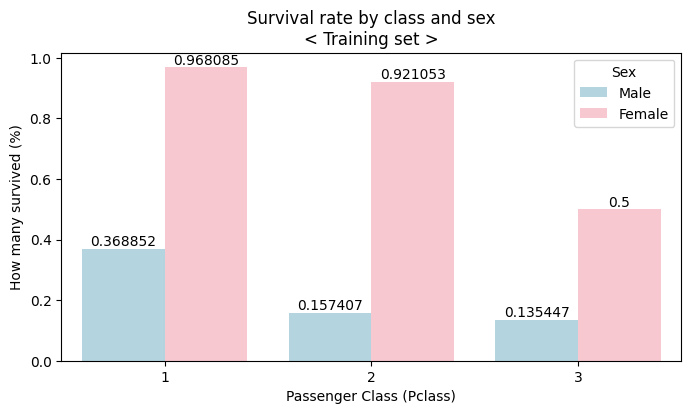

Survived/perished relationship in PREDICTED data:
                     PClass1        PClass2        Pclass3
Male/Survived...:  35.087719%     04.761905%     07.534247%
Male/Perished...:  64.912281%     95.238095%     92.465753%
                        *              *              *
Female/Survived.:  100.000000%     100.000000%     59.722222%
Female/Perished.:  00.000000%     00.000000%     40.277778%


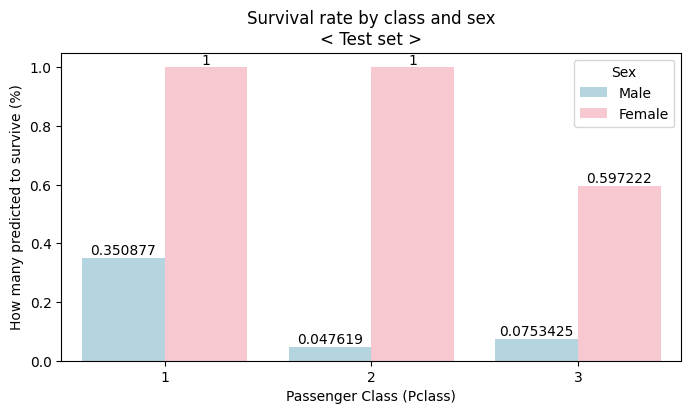


Features que foram utilizadas no modelo e que tiveram relevância no algoritmo:
        variável  importância
3         isMale    27.041503
28      Title_Mr    23.830838
1           Fare    13.253887
0            Age    11.645415
8       Pclass_3    10.762374
16       Cabin_U     2.407012
12       Cabin_E     2.020642
24  Title_Master     1.578381
31     Title_Rev     1.459292
4         Grupo1     1.407444
11       Cabin_D     1.169646
7       Pclass_2     0.885986
10       Cabin_C     0.633227
29     Title_Mrs     0.567166
5         Grupo2     0.549812
20      Title_Dr     0.398712
25    Title_Miss     0.109585
18     Title_Don     0.092450
23   Title_Major     0.069922
17     Title_Col     0.050504
9        Cabin_B     0.035820
32     Title_Sir     0.012189
22    Title_Lady     0.007060
14       Cabin_G     0.005404
6         Grupo3     0.002779
2       Noblesse     0.002473
15       Cabin_T     0.000441
13       Cabin_F     0.000035

Features sem importância: ['Title_Dona' 'Title_Jo

In [178]:
warnings.filterwarnings("ignore") # inibe os avisos dessa seção, volta ao normal no fim

# A previsão propriamente dita
#valid_xgb = valid.drop(var_remove, axis = 1)
ypred_cat_final = classif_cat.predict(valid)

# Cálculos e procedimentos necessários anteriores às impressões em terminal ou arquivo
# Cópia do banco de dados antes de OHE (menos memória ocupada)
dados_cat = dados_full.copy()
paleta = {"Male": "lightblue", "Female": "pink"}

# Impostação do resultado obtido
mask = dados_cat['origem'] == 'teste'
dados_cat.loc[mask, 'Survived'] = ypred_cat_final

# A apresentação em terminal
print("###### MODELO CatBoost " + nome_modelo + " ######")
print("\nInformações geradas em " + datetime.now().strftime("%d-%m-%Y") + " às " + datetime.now().strftime("%H:%M") + ".\n")

print(f'Coeficiente de Determinação R2: {score_cat_r2:.6f}')
print(f'Score de validação cruzada: {cv_scores_cat.mean():.6f}\n')

# Dos dados de Treino
print('---===+++ Predicted and historical ranking comparison +++===---\n')
print('Survived/perished relationship in TRAINING data:')

    # Máscaras
mask1 = dados_cat[(dados_cat['Pclass'] == 1) & (dados_cat['origem'] == 'treino')].index
mask2 = dados_cat[(dados_cat['Pclass'] == 2) & (dados_cat['origem'] == 'treino')].index
mask3 = dados_cat[(dados_cat['Pclass'] == 3) & (dados_cat['origem'] == 'treino')].index
    
    # Relação de sobreviventes ou não da 1a classe
ms1 = (len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Male')])*100)
md1 = (len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Male')])*100)
fs1 = (len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Female')])*100)
fd1 = (len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Female')])*100)

    # Relação de sobreviventes ou não da 2a classe
ms2 = (len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Male')])*100)
md2 = (len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Male')])*100)
fs2 = (len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Female')])*100)
fd2 = (len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Female')])*100)

    # Relação de sobreviventes ou não da 3a classe
ms3 = (len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Male')])*100)
md3 = (len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Male')])*100)
fs3 = (len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Female')])*100)
fd3 = (len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Female')])*100)

print(f'                     PClass1        PClass2        Pclass3')
print(f'Male/Survived...:  {ms1:0>9f}%     {ms2:0>9f}%     {ms3:0>9f}%')
print(f'Male/Perished...:  {md1:0>9f}%     {md2:0>9f}%     {md3:0>9f}%')
print(f'                        *              *              *')
print(f'Female/Survived.:  {fs1:0>9f}%     {fs2:0>9f}%     {fs3:0>9f}%')
print(f'Female/Perished.:  {fd1:0>9f}%     {fd2:0>9f}%     {fd3:0>9f}%')

# Prints the train graph
plt.figure(figsize =(8, 4))
sns.color_palette("pastel")
grafico_treino = sns.barplot(data=dados_cat[dados_cat['origem'] == 'treino'], x='Pclass', y='Survived', hue = 'Sex', hue_order = ['Male', 'Female'], palette = paleta, errorbar = None)
grafico_treino.bar_label(grafico_treino.containers[0], fontsize=10)
grafico_treino.bar_label(grafico_treino.containers[1], fontsize=10)
plt.ylabel("How many survived (%)")
plt.xlabel('Passenger Class (Pclass)')
plt.title("Survival rate by class and sex\n< Training set >")
plt.show()

# Dos dados de teste
print('Survived/perished relationship in PREDICTED data:')

mask1 = dados_cat[(dados_cat['Pclass'] == 1) & (dados_cat['origem'] == 'teste')].index
mask2 = dados_cat[(dados_cat['Pclass'] == 2) & (dados_cat['origem'] == 'teste')].index
mask3 = dados_cat[(dados_cat['Pclass'] == 3) & (dados_cat['origem'] == 'teste')].index
    
    # Relação de sobreviventes ou não da 1a classe
ms1 = (len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Male')])*100)
md1 = (len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Male')])*100)
fs1 = (len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Female')])*100)
fd1 = (len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Female')])*100)

    # Relação de sobreviventes ou não da 2a classe
ms2 = (len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Male')])*100)
md2 = (len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Male')])*100)
fs2 = (len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Female')])*100)
fd2 = (len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Female')])*100)

    # Relação de sobreviventes ou não da 3a classe
ms3 = (len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Male')])*100)
md3 = (len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Male')])*100)
fs3 = (len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Female')])*100)
fd3 = (len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Female')])*100)


print(f'                     PClass1        PClass2        Pclass3')
print(f'Male/Survived...:  {ms1:0>9f}%     {ms2:0>9f}%     {ms3:0>9f}%')
print(f'Male/Perished...:  {md1:0>9f}%     {md2:0>9f}%     {md3:0>9f}%')
print(f'                        *              *              *')
print(f'Female/Survived.:  {fs1:0>9f}%     {fs2:0>9f}%     {fs3:0>9f}%')
print(f'Female/Perished.:  {fd1:0>9f}%     {fd2:0>9f}%     {fd3:0>9f}%')

# Prints the test graph
plt.figure(figsize =(8, 4))
grafico_teste = sns.barplot(data=dados_cat[dados_cat['origem'] == 'teste'], x='Pclass', y='Survived', hue = 'Sex', hue_order = ['Male', 'Female'], palette = paleta, errorbar = None)
grafico_teste.bar_label(grafico_teste.containers[0], fontsize=10)
grafico_teste.bar_label(grafico_teste.containers[1], fontsize=10)
plt.ylabel("How many predicted to survive (%)")
plt.xlabel('Passenger Class (Pclass)')
plt.title("Survival rate by class and sex\n< Test set >")
plt.show()
warnings.filterwarnings("default")

print("\nFeatures que foram utilizadas no modelo e que tiveram relevância no algoritmo:")
importancias = pd.DataFrame(classif_cat.feature_importances_, classif_cat.feature_names_)
importancias.reset_index(inplace = True)
importancias.columns = ["variável", "importância"]
print(importancias[importancias['importância'] > 0].sort_values(by = "importância", ascending = False))
if discard_index.sum() > 0:
    print("\nFeatures sem importância:", dados_treino.columns.values[discard_index], ".\n")
else: print("\nNão foram identificadas features sem importância.\n")

print(f'Coeficiente de Determinação R2: {score_cat_r2:.6f}')
print(f'Score de validação cruzada: {cv_scores_cat.mean():.6f}\n')

verif_outliers()

print("Parâmetros do modelo:")
print(classif_cat.get_all_params())
print("\n=======================================================================")

Manipulação da última previsão realizada para submissão

In [179]:
print(f'Previsão em uso possui registro {nome_modelo}.')
print("Compilando nome de arquivo para submissão...")
# Composição do nome a ser salvo
ext_final = (".csv")
save_final = ("resultado_CatBoostClassifier_"+(nome_modelo + ext_final))

print("Gerando arquivo de submissão com nome " + save_final)
# Leitura do arquivo de submisão, registro dos dados obtidos e regravação do arquivo com estes dados
submissao = pd.read_csv("./dados/gender_submission.csv")
submissao["Survived"] = ypred_cat_final
submissao.to_csv("./resultados/"+save_final, index=False)

print("\nProcedimento realizado com sucesso. O arquivo em questão encontra-se na pasta de destino ('./resultados/').")

Previsão em uso possui registro 20240704-0848.
Compilando nome de arquivo para submissão...
Gerando arquivo de submissão com nome resultado_CatBoostClassifier_20240704-0848.csv

Procedimento realizado com sucesso. O arquivo em questão encontra-se na pasta de destino ('./resultados/').


Confusion Matrix

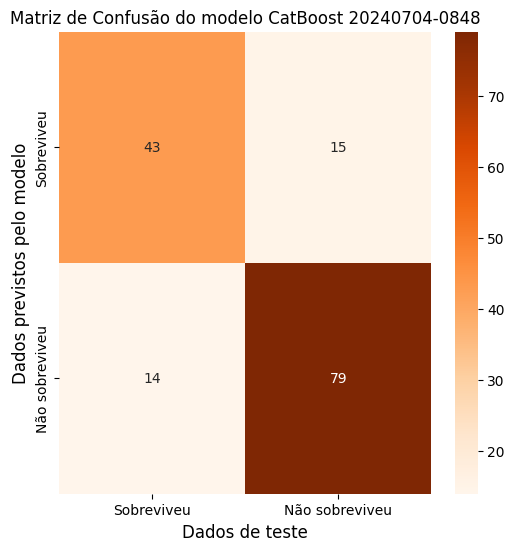

In [180]:
# O parâmetro 'labels' identifica as classificações dentro das variáveis, a primeira sendo a variável positiva e a segunda, a negativa
# Pela lógica, positiva aqui significa 'sobrevivente'.

conf_matrix = metrics.confusion_matrix(teste_y.Survived.values.astype('int'), ypred_cat, labels=[1, 0])

# Plotagem da matriz
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix,
            annot = True,
            cmap = 'Oranges',
            xticklabels = ['Sobreviveu', 'Não sobreviveu'],
            yticklabels = ['Sobreviveu', 'Não sobreviveu'])
plt.title(f'Matriz de Confusão do modelo CatBoost {nome_modelo}', fontsize=12)
plt.xlabel('Dados de teste', fontsize=12)
plt.ylabel('Dados previstos pelo modelo', fontsize=12)
plt.show()

### Registro para consulta

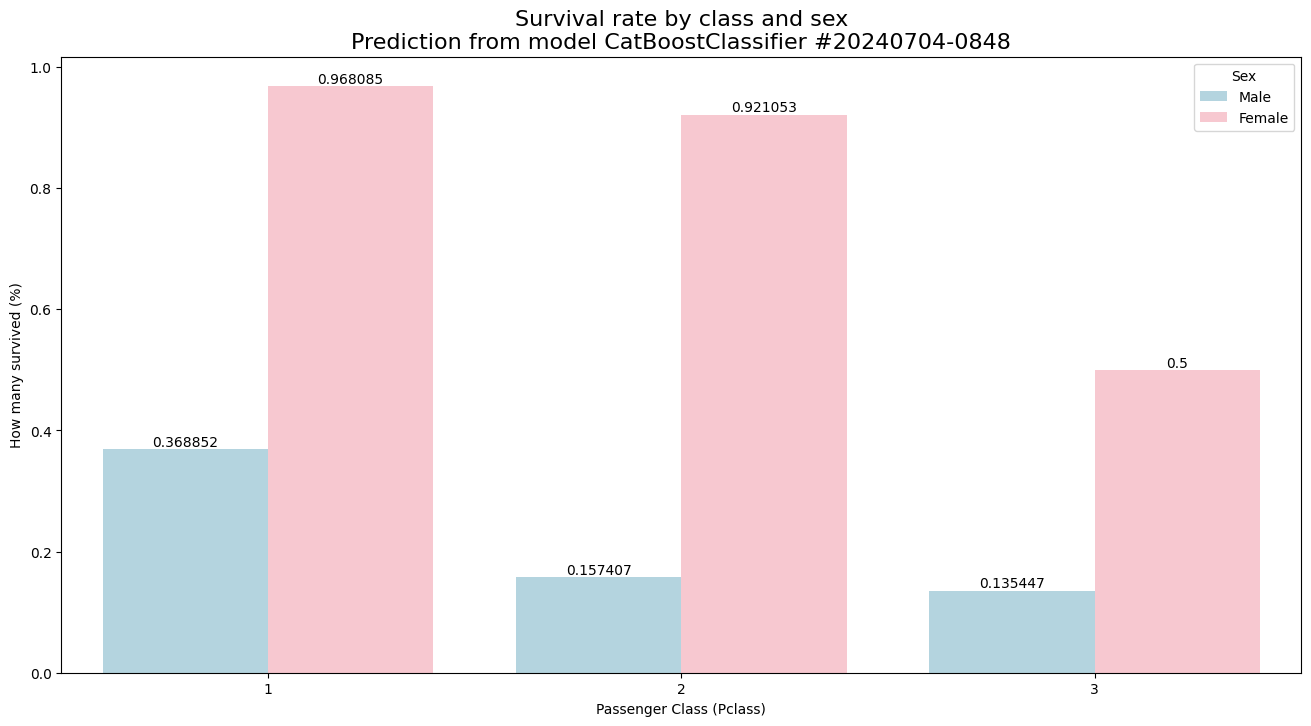

In [181]:
with open("./registros/registros_catboost.txt", "a") as registros:
    registros.write("########## INÍCIO DE REGISTRO - MODELO CatBoostClassifier " + nome_modelo + " ##########\n")
    registros.write("\nInformações geradas em " + datetime.now().strftime("%d-%m-%Y") + " às " + datetime.now().strftime("%H:%M") + ".\n")
    warnings.filterwarnings("ignore") # inibe os avisos dessa seção, volta ao normal no fim

    # Impostação do resultado obtido
    mask = dados_cat['origem'] == 'teste'
    dados_cat.loc[mask, 'Survived'] = ypred_cat_final

    # Dos dados de Treino
    registros.write('\n---===+++ Predicted and historical ranking comparison +++===---\n')
    registros.write('\nSurvived/perished relationship in *TRAINING* data:\n')

        # Máscaras
    mask1 = dados_cat[(dados_cat['Pclass'] == 1) & (dados_cat['origem'] == 'treino')].index
    mask2 = dados_cat[(dados_cat['Pclass'] == 2) & (dados_cat['origem'] == 'treino')].index
    mask3 = dados_cat[(dados_cat['Pclass'] == 3) & (dados_cat['origem'] == 'treino')].index
    
        # Relação de sobreviventes ou não da 1a classe
    ms1 = (len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Male')])*100)
    md1 = (len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Male')])*100)
    fs1 = (len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Female')])*100)
    fd1 = (len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Female')])*100)

        # Relação de sobreviventes ou não da 2a classe
    ms2 = (len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Male')])*100)
    md2 = (len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Male')])*100)
    fs2 = (len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Female')])*100)
    fd2 = (len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Female')])*100)

        # Relação de sobreviventes ou não da 3a classe
    ms3 = (len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Male')])*100)
    md3 = (len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Male')])*100)
    fs3 = (len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Female')])*100)
    fd3 = (len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Female')])*100)

    registros.write(f'                     PClass1        PClass2        Pclass3\n')
    registros.write(f'Male/Survived...:  {ms1:0>9f}%     {ms2:0>9f}%     {ms3:0>9f}%\n')
    registros.write(f'Male/Perished...:  {md1:0>9f}%     {md2:0>9f}%     {md3:0>9f}%\n')
    registros.write(f'                        *              *              *\n')
    registros.write(f'Female/Survived.:  {fs1:0>9f}%     {fs2:0>9f}%     {fs3:0>9f}%\n')
    registros.write(f'Female/Perished.:  {fd1:0>9f}%     {fd2:0>9f}%     {fd3:0>9f}%\n')

    # Das previsões
    registros.write('\nSurvived/perished relationship in *PREDICTED* data:\n')

    mask1 = dados_cat[(dados_cat['Pclass'] == 1) & (dados_cat['origem'] == 'teste')].index
    mask2 = dados_cat[(dados_cat['Pclass'] == 2) & (dados_cat['origem'] == 'teste')].index
    mask3 = dados_cat[(dados_cat['Pclass'] == 3) & (dados_cat['origem'] == 'teste')].index

        # Relação de sobreviventes ou não da 1a classe
    ms1 = (len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Male')])*100)
    md1 = (len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Male')])*100)
    fs1 = (len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Female')])*100)
    fd1 = (len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask1][(dados_cat['Sex'] == 'Female')])*100)

        # Relação de sobreviventes ou não da 2a classe
    ms2 = (len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Male')])*100)
    md2 = (len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Male')])*100)
    fs2 = (len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Female')])*100)
    fd2 = (len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask2][(dados_cat['Sex'] == 'Female')])*100)

        # Relação de sobreviventes ou não da 3a classe
    ms3 = (len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Male')])*100)
    md3 = (len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Male') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Male')])*100)
    fs3 = (len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 1)]) / len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Female')])*100)
    fd3 = (len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Female') & (dados_cat['Survived'] == 0)]) / len(dados_cat.loc[mask3][(dados_cat['Sex'] == 'Female')])*100)


    registros.write(f'                     PClass1        PClass2        Pclass3\n')
    registros.write(f'Male/Survived...:  {ms1:0>9f}%     {ms2:0>9f}%     {ms3:0>9f}%\n')
    registros.write(f'Male/Perished...:  {md1:0>9f}%     {md2:0>9f}%     {md3:0>9f}%\n')
    registros.write(f'                        *              *              *\n')
    registros.write(f'Female/Survived.:  {fs1:0>9f}%     {fs2:0>9f}%     {fs3:0>9f}%\n')
    registros.write(f'Female/Perished.:  {fd1:0>9f}%     {fd2:0>9f}%     {fd3:0>9f}%\n')

    # Prints the predictions graph
    ext_graph = (".png")
    name_graph = ("previsoes_CatBoostClassifier_"+(nome_modelo + ext_graph))
    plt.figure(figsize =(16, 8))
    sns.color_palette("pastel")
    graph = sns.barplot(data=dados_cat[dados_cat['origem'] == 'treino'], x='Pclass', y='Survived', hue = 'Sex', hue_order = ['Male', 'Female'], palette = paleta, errorbar = None)
    graph.bar_label(graph.containers[0], fontsize=10)
    graph.bar_label(graph.containers[1], fontsize=10)
    plt.ylabel("How many survived (%)")
    plt.xlabel('Passenger Class (Pclass)')
    plt.title(f'Survival rate by class and sex\nPrediction from model CatBoostClassifier #{nome_modelo}', fontsize = 16)
    fig = graph.get_figure()
    fig.savefig('./imagens/'+name_graph)

    registros.write("\nFeatures que foram utilizadas no modelo e que tiveram relevância no algoritmo:\n")
    importancias = pd.DataFrame(classif_cat.feature_importances_, classif_cat.feature_names_)
    importancias.reset_index(inplace = True)
    importancias.columns = ["variável", "importância"]
    registros.write(str(importancias[importancias['importância'] > 0].sort_values(by = "importância", ascending = False)))
    if discard_index.sum() > 0:
        registros.write("\n\nFeatures sem importância:"+ str(dados_treino.columns.values[discard_index]) + ".\n")
    else: registros.write("\n\nNão foram identificadas features sem importância.\n")

    registros.write(f'\nCoeficiente de Determinação R2: {score_cat_r2:.6f}\n')
    registros.write(f'Score de validação cruzada: {cv_scores_cat.mean():.6f}\n\n')

    if dados_cat.Fare.max() > 300: registros.write("Outliers em 'Fare' identificados.\n")
    else: registros.write("Não foram identificados outliers (somente 'Fare' é passível de ter outliers).\n")


    registros.write("\nParâmetros do modelo:\n")
    registros.write(str(classif_cat.get_all_params()))
    registros.write("\n\n=======================================================================\n\n\n")

## LightGBM

### Modelo

In [182]:
from lightgbm import LGBMClassifier

# Estabelecimento do nome do modelo para fins de registro
nome_modelo = datetime.now().strftime("%Y%m%d-%H%M")

classif_lgbm = LGBMClassifier(boosting_type = 'gbdt', # 'gbdt' default, 'rf'
                              num_leaves = 16, # default 31
                              max_depth = 3, # <0 é sem limite
                              learning_rate = 0.044,
                              n_estimators = 800, # default 100
                              objective = 'binary',
                              min_split_gain=0.02, 
                              min_child_weight=0.022,
                              min_child_samples=47, # default 20
                              subsample=0.6, # default 1
                              random_state=1,
                              n_jobs=12,
                              importance_type='split',
                              metric = 'binary_logloss' # 'map', 'auc', 'average_precision', 'binary_logloss', 'binary_error, 'auc_mu', 'logloss'
                              )

verif_outliers()

classif_lgbm.fit(treino_x, treino_y,
            eval_set = (teste_x, teste_y))

ypred_lgbm = classif_lgbm.predict(teste_x)
score_lgbm_r2 = r2_score(teste_y, ypred_lgbm)

cv_scores_lgbm = cross_val_score(classif_lgbm, treino_x, y = treino_y, # estimador (usado no fit), X, y (se existente)
                                       cv = 5, # None: default 5-fold cross validation
                                       n_jobs = 12,
                                       verbose = 0,
                                       params = {'eval_set':(teste_x, teste_y)}, 
                                       error_score = 'raise')


discard_index = classif_lgbm.feature_importances_ == 0
print(f'\nCoeficiente de determinação: {score_lgbm_r2:.6f}')
print(f'Score de validação cruzada: {cv_scores_lgbm.mean():.6f}')

# Verifica a existência de variáveis desprezíveis utilizadas na modelagem
if discard_index.sum() > 0:
    print("\nATENÇÃO! Variáveis sem importância encontradas!")
    print("\nPodem ser descartadas as variáveis: ", dados_treino.columns.values[discard_index])
else: print("\nTodas variáveis utilizadas, nenhuma sem importância.")

Não foram identificados outliers (somente 'Fare' é passível de ter outliers).

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 202, number of negative: 402
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 604, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334437 -> initscore=-0.688184
[LightGBM] [Info] Start training from score -0.688184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/thiago/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/thiago/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/thiago/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/thiago/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/p

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 161, number of negative: 322
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 161, number of negative: 322
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of data points in the train set: 483, number of used features: 10
[LightGBM] [Info] Number of positive: 162, number of negative: 322
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.69

/home/thiago/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/thiago/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/thiago/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/thiago/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/p

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 162, number of negative: 321
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 162, number of negative: 321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 483, number of used features: 9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335404 -> initscore=-0.683845
[LightGBM] [Info] Start training from score -0.683845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

### Optuna

In [183]:
"""
# Define a função que vai testar os hiperparâmetros
def objective(testar):
#    boosting_type = testar.suggest_categorical('boosting_type', ['gbdt', 'rf'])
    num_leaves = testar.suggest_int('num_leaves', 12, 64, step = 4)    
    max_depth = testar.suggest_int('max_depth', 2, 30)
    n_estimators = testar.suggest_int('n_estimators', 500, 2500, step = 100)
    learning_rate = testar.suggest_float('learning_rate', 0.001, 0.050, step = 0.001)
    min_split_gain = testar.suggest_float('min_split_gain', 0.01, 0.15, step = 0.005)
    min_child_weight = testar.suggest_float('min_child_weight', 0.001, 0.050, step = 0.001)
    min_child_samples = testar.suggest_int('min_child_samples', 1, 50, step = 2)
    subsample = testar.suggest_float('subsample', 0.1, 1, step = 0.1)
    metric = testar.suggest_categorical('metric', ['logloss', 'auc', 'average_precision', 'binary_logloss', 'binary_error'])

    classif_lgbm = LGBMClassifier(boosting_type = 'gbdt',
                              num_leaves = num_leaves,
                              max_depth = max_depth,
                              n_estimators = n_estimators,
                              learning_rate = learning_rate,
                              objective = 'binary',
                              min_split_gain=min_split_gain, 
                              min_child_weight=min_child_weight,
                              min_child_samples=min_child_samples,
                              subsample=subsample,
                              random_state=1,
                              n_jobs=12,
                              importance_type='split',
                              metric = metric
                              )
    
    classif_lgbm.fit(treino_x, treino_y,
            eval_set = (teste_x, teste_y))

    cv_scores_lgbm = cross_val_score(classif_lgbm, treino_x, y = treino_y,
                                       cv = 5,
                                       n_jobs = 10,
                                       verbose = 0,
                                       params = {'eval_set':(teste_x, teste_y)}, 
                                       error_score = 'raise')
    
    return cv_scores_lgbm.mean()

# Cria o objeto de estudo dos parâmetros
optuna_lgbm = optuna.create_study(direction = 'maximize',
                                 sampler = optuna.samplers.RandomSampler(seed = 1))

# Começa a realizar os testes de iteração
warnings.filterwarnings("ignore") # inibe os avisos dessa seção, volta ao normal no fim
optuna_lgbm.optimize(objective, n_trials= 10)
warnings.filterwarnings("default")

# Armazena os melhores parâmetros em um objeto
melhores_optuna_lgbm = optuna_lgbm.best_params
"""

'\n# Define a função que vai testar os hiperparâmetros\ndef objective(testar):\n#    boosting_type = testar.suggest_categorical(\'boosting_type\', [\'gbdt\', \'rf\'])\n    num_leaves = testar.suggest_int(\'num_leaves\', 12, 64, step = 4)    \n    max_depth = testar.suggest_int(\'max_depth\', 2, 30)\n    n_estimators = testar.suggest_int(\'n_estimators\', 500, 2500, step = 100)\n    learning_rate = testar.suggest_float(\'learning_rate\', 0.001, 0.050, step = 0.001)\n    min_split_gain = testar.suggest_float(\'min_split_gain\', 0.01, 0.15, step = 0.005)\n    min_child_weight = testar.suggest_float(\'min_child_weight\', 0.001, 0.050, step = 0.001)\n    min_child_samples = testar.suggest_int(\'min_child_samples\', 1, 50, step = 2)\n    subsample = testar.suggest_float(\'subsample\', 0.1, 1, step = 0.1)\n    metric = testar.suggest_categorical(\'metric\', [\'logloss\', \'auc\', \'average_precision\', \'binary_logloss\', \'binary_error\'])\n\n    classif_lgbm = LGBMClassifier(boosting_type =

In [184]:
# Gráficos diversos sobre o estudo realizado
#optuna.visualization.plot_optimization_history(optuna_lgbm)

#optuna.visualization.plot_param_importances(optuna_lgbm)

#optuna.visualization.plot_parallel_coordinate(optuna_lgbm)

#optuna.visualization.plot_slice(optuna_lgbm, params = ['num_leaves', 'max_depth', 'n_estimators', 'learning_rate', 'min_split_gain', 'min_child_weight', 'min_child_samples', 'subsample', 'metric'])

In [185]:
"""
# Realiza o registro em arquivo texto para posterior consulta
with open("./registros/optuna_lgbmclassifier.txt", "a") as registros:
    registros.write("########## INÍCIO DE REGISTRO OPTUNA - MODELO LightGBM Classifier ##########\n")
    registros.write("\nInformações armazenadas em " + datetime.now().strftime("%d-%m-%Y") + " às " + datetime.now().strftime("%H:%M") + ".\n")
    
    registros.write('\n---===+++ Os melhores parâmetros encontrados +++===---\n\n')
    registros.write(str(melhores_optuna_lgbm))
    registros.write(f'\n\nObtidos na iteração {optuna_lgbm.best_trial.number}\n')
    registros.write(f'Valor de score cross-validation {optuna_lgbm.best_value}\n\n')
    registros.write("########## FINAL DE REGISTRO OPTUNA - MODELO LightGBM Classifier ##########\n\n\n")
"""

'\n# Realiza o registro em arquivo texto para posterior consulta\nwith open("./registros/optuna_lgbmclassifier.txt", "a") as registros:\n    registros.write("########## INÍCIO DE REGISTRO OPTUNA - MODELO LightGBM Classifier ##########\n")\n    registros.write("\nInformações armazenadas em " + datetime.now().strftime("%d-%m-%Y") + " às " + datetime.now().strftime("%H:%M") + ".\n")\n    \n    registros.write(\'\n---===+++ Os melhores parâmetros encontrados +++===---\n\n\')\n    registros.write(str(melhores_optuna_lgbm))\n    registros.write(f\'\n\nObtidos na iteração {optuna_lgbm.best_trial.number}\n\')\n    registros.write(f\'Valor de score cross-validation {optuna_lgbm.best_value}\n\n\')\n    registros.write("########## FINAL DE REGISTRO OPTUNA - MODELO LightGBM Classifier ##########\n\n\n")\n'

### Previsão do modelo e geração do arquivo de submissão

###### MODELO LightGBM 20240704-0848 ######

Informações geradas em 04-07-2024 às 08:49.

Coeficiente de Determinação R2: 0.160178
Score de validação cruzada: 0.832837

---===+++ Predicted and historical ranking comparison +++===---

Survived/perished relationship in TRAINING data:
                     PClass1        PClass2        Pclass3
Male/Survived...:  36.885246%     15.740741%     13.544669%
Male/Perished...:  63.114754%     84.259259%     86.455331%
                        *              *              *
Female/Survived.:  96.808511%     92.105263%     50.000000%
Female/Perished.:  03.191489%     07.894737%     50.000000%


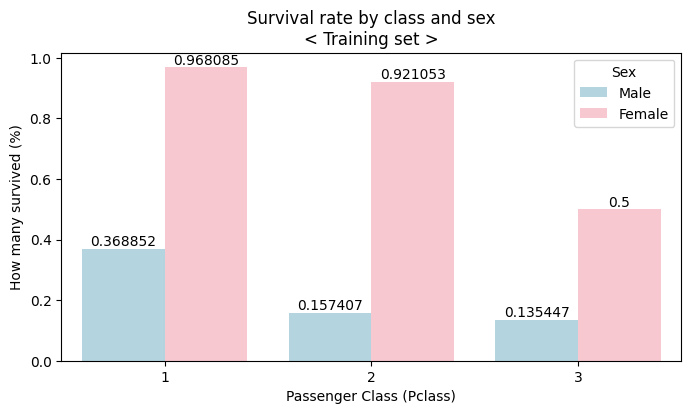

Survived/perished relationship in PREDICTED data:
                     PClass1        PClass2        Pclass3
Male/Survived...:  19.298246%     07.936508%     07.534247%
Male/Perished...:  80.701754%     92.063492%     92.465753%
                        *              *              *
Female/Survived.:  100.000000%     100.000000%     62.500000%
Female/Perished.:  00.000000%     00.000000%     37.500000%


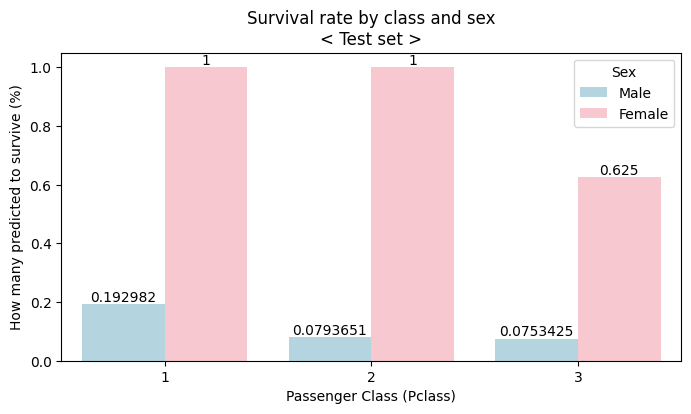


Features que foram utilizadas no modelo e que tiveram relevância no algoritmo:
     variável  importância
1        Fare         1350
0         Age         1286
29  Title_Mrs          143
3      isMale          106
4      Grupo1           82
8    Pclass_3           74
16    Cabin_U           61
28   Title_Mr           45
7    Pclass_2            3

Features sem importância: ['Noblesse' 'Grupo2' 'Grupo3' 'Cabin_B' 'Cabin_C' 'Cabin_D' 'Cabin_E'
 'Cabin_F' 'Cabin_G' 'Cabin_T' 'Title_Col' 'Title_Don' 'Title_Dona'
 'Title_Dr' 'Title_Jonkheer' 'Title_Lady' 'Title_Major' 'Title_Master'
 'Title_Miss' 'Title_Mlle' 'Title_Mme' 'Title_Ms' 'Title_Rev' 'Title_Sir'
 'Title_the Countess'] .

Coeficiente de Determinação R2: 0.160178

Não foram identificados outliers (somente 'Fare' é passível de ter outliers).

Parâmetros do modelo:
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.044, 'max_depth': 3, 'min_child_samples': 47, 'min_

In [186]:
warnings.filterwarnings("ignore") # inibe os avisos dessa seção, volta ao normal no fim

# A previsão propriamente dita
#valid_xgb = valid.drop(var_remove, axis = 1)
ypred_lgbm_final = classif_lgbm.predict(valid)

# Cálculos e procedimentos necessários anteriores às impressões em terminal ou arquivo
# Cópia do banco de dados antes de OHE (menos memória ocupada)
dados_lgbm = dados_full.copy()
paleta = {"Male": "lightblue", "Female": "pink"}

# Impostação do resultado obtido
mask = dados_lgbm['origem'] == 'teste'
dados_lgbm.loc[mask, 'Survived'] = ypred_lgbm_final

# A apresentação em terminal
print("###### MODELO LightGBM " + nome_modelo + " ######")
print("\nInformações geradas em " + datetime.now().strftime("%d-%m-%Y") + " às " + datetime.now().strftime("%H:%M") + ".\n")

print(f'Coeficiente de Determinação R2: {score_lgbm_r2:.6f}')
print(f'Score de validação cruzada: {cv_scores_lgbm.mean():.6f}\n')

# Dos dados de Treino
print('---===+++ Predicted and historical ranking comparison +++===---\n')
print('Survived/perished relationship in TRAINING data:')

    # Máscaras
mask1 = dados_lgbm[(dados_lgbm['Pclass'] == 1) & (dados_lgbm['origem'] == 'treino')].index
mask2 = dados_lgbm[(dados_lgbm['Pclass'] == 2) & (dados_lgbm['origem'] == 'treino')].index
mask3 = dados_lgbm[(dados_lgbm['Pclass'] == 3) & (dados_lgbm['origem'] == 'treino')].index
    
    # Relação de sobreviventes ou não da 1a classe
ms1 = (len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Male')])*100)
md1 = (len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Male')])*100)
fs1 = (len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Female')])*100)
fd1 = (len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Female')])*100)

    # Relação de sobreviventes ou não da 2a classe
ms2 = (len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Male')])*100)
md2 = (len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Male')])*100)
fs2 = (len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Female')])*100)
fd2 = (len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Female')])*100)

    # Relação de sobreviventes ou não da 3a classe
ms3 = (len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Male')])*100)
md3 = (len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Male')])*100)
fs3 = (len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Female')])*100)
fd3 = (len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Female')])*100)

print(f'                     PClass1        PClass2        Pclass3')
print(f'Male/Survived...:  {ms1:0>9f}%     {ms2:0>9f}%     {ms3:0>9f}%')
print(f'Male/Perished...:  {md1:0>9f}%     {md2:0>9f}%     {md3:0>9f}%')
print(f'                        *              *              *')
print(f'Female/Survived.:  {fs1:0>9f}%     {fs2:0>9f}%     {fs3:0>9f}%')
print(f'Female/Perished.:  {fd1:0>9f}%     {fd2:0>9f}%     {fd3:0>9f}%')

# Prints the train graph
plt.figure(figsize =(8, 4))
sns.color_palette("pastel")
grafico_treino = sns.barplot(data=dados_lgbm[dados_lgbm['origem'] == 'treino'], x='Pclass', y='Survived', hue = 'Sex', hue_order = ['Male', 'Female'], palette = paleta, errorbar = None)
grafico_treino.bar_label(grafico_treino.containers[0], fontsize=10)
grafico_treino.bar_label(grafico_treino.containers[1], fontsize=10)
plt.ylabel("How many survived (%)")
plt.xlabel('Passenger Class (Pclass)')
plt.title("Survival rate by class and sex\n< Training set >")
plt.show()


# Dos dados de teste
print('Survived/perished relationship in PREDICTED data:')

mask1 = dados_lgbm[(dados_lgbm['Pclass'] == 1) & (dados_lgbm['origem'] == 'teste')].index
mask2 = dados_lgbm[(dados_lgbm['Pclass'] == 2) & (dados_lgbm['origem'] == 'teste')].index
mask3 = dados_lgbm[(dados_lgbm['Pclass'] == 3) & (dados_lgbm['origem'] == 'teste')].index
    
    # Relação de sobreviventes ou não da 1a classe
ms1 = (len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Male')])*100)
md1 = (len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Male')])*100)
fs1 = (len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Female')])*100)
fd1 = (len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Female')])*100)

    # Relação de sobreviventes ou não da 2a classe
ms2 = (len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Male')])*100)
md2 = (len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Male')])*100)
fs2 = (len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Female')])*100)
fd2 = (len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Female')])*100)

    # Relação de sobreviventes ou não da 3a classe
ms3 = (len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Male')])*100)
md3 = (len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Male')])*100)
fs3 = (len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Female')])*100)
fd3 = (len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Female')])*100)


print(f'                     PClass1        PClass2        Pclass3')
print(f'Male/Survived...:  {ms1:0>9f}%     {ms2:0>9f}%     {ms3:0>9f}%')
print(f'Male/Perished...:  {md1:0>9f}%     {md2:0>9f}%     {md3:0>9f}%')
print(f'                        *              *              *')
print(f'Female/Survived.:  {fs1:0>9f}%     {fs2:0>9f}%     {fs3:0>9f}%')
print(f'Female/Perished.:  {fd1:0>9f}%     {fd2:0>9f}%     {fd3:0>9f}%')

# Prints the test graph
plt.figure(figsize =(8, 4))
grafico_teste = sns.barplot(data=dados_lgbm[dados_lgbm['origem'] == 'teste'], x='Pclass', y='Survived', hue = 'Sex', hue_order = ['Male', 'Female'], palette = paleta, errorbar = None)
grafico_teste.bar_label(grafico_teste.containers[0], fontsize=10)
grafico_teste.bar_label(grafico_teste.containers[1], fontsize=10)
plt.ylabel("How many predicted to survive (%)")
plt.xlabel('Passenger Class (Pclass)')
plt.title("Survival rate by class and sex\n< Test set >")
plt.show()
warnings.filterwarnings("default")

print("\nFeatures que foram utilizadas no modelo e que tiveram relevância no algoritmo:")
importancias = pd.DataFrame(classif_lgbm.feature_importances_, classif_lgbm.feature_name_)
importancias.reset_index(inplace = True)
importancias.columns = ["variável", "importância"]
print(importancias[importancias['importância'] > 0].sort_values(by = "importância", ascending = False))
if discard_index.sum() > 0:
    print("\nFeatures sem importância:", dados_treino.columns.values[discard_index], ".\n")
else: print("\nNão foram identificadas features sem importância.\n")

print(f'Coeficiente de Determinação R2: {score_lgbm_r2:.6f}\n')

verif_outliers()

print("Parâmetros do modelo:")
print(classif_lgbm.get_params())
print("\n=======================================================================")

Manipulação da última previsão realizada para submissão

In [187]:
print(f'Previsão em uso possui registro {nome_modelo}.')
print("Compilando nome de arquivo para submissão...")
# Composição do nome a ser salvo
ext_final = (".csv")
save_final = ("resultado_LightGBMClassifier_"+(nome_modelo + ext_final))

print("Gerando arquivo de submissão com nome " + save_final)
# Leitura do arquivo de submisão, registro dos dados obtidos e regravação do arquivo com estes dados
submissao = pd.read_csv("./dados/gender_submission.csv")
submissao["Survived"] = ypred_lgbm_final.astype('int')
submissao.to_csv("./resultados/"+save_final, index=False)

print("\nProcedimento realizado com sucesso. O arquivo em questão encontra-se na pasta de destino ('./resultados/').")

Previsão em uso possui registro 20240704-0848.
Compilando nome de arquivo para submissão...
Gerando arquivo de submissão com nome resultado_LightGBMClassifier_20240704-0848.csv

Procedimento realizado com sucesso. O arquivo em questão encontra-se na pasta de destino ('./resultados/').


Confusion Matrix

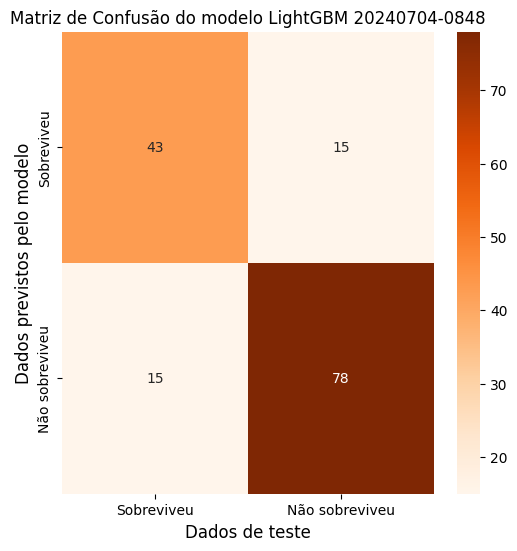

In [188]:
# O parâmetro 'labels' identifica as classificações dentro das variáveis, a primeira sendo a variável positiva e a segunda, a negativa
# Pela lógica, positiva aqui significa 'sobrevivente'.

conf_matrix = metrics.confusion_matrix(teste_y.Survived.values.astype('int'), ypred_lgbm, labels=[1, 0])

# Plotagem da matriz
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix,
            annot = True,
            cmap = 'Oranges',
            xticklabels = ['Sobreviveu', 'Não sobreviveu'],
            yticklabels = ['Sobreviveu', 'Não sobreviveu'])
plt.title(f'Matriz de Confusão do modelo LightGBM {nome_modelo}', fontsize=12)
plt.xlabel('Dados de teste', fontsize=12)
plt.ylabel('Dados previstos pelo modelo', fontsize=12)
plt.show()

### Registro para consulta

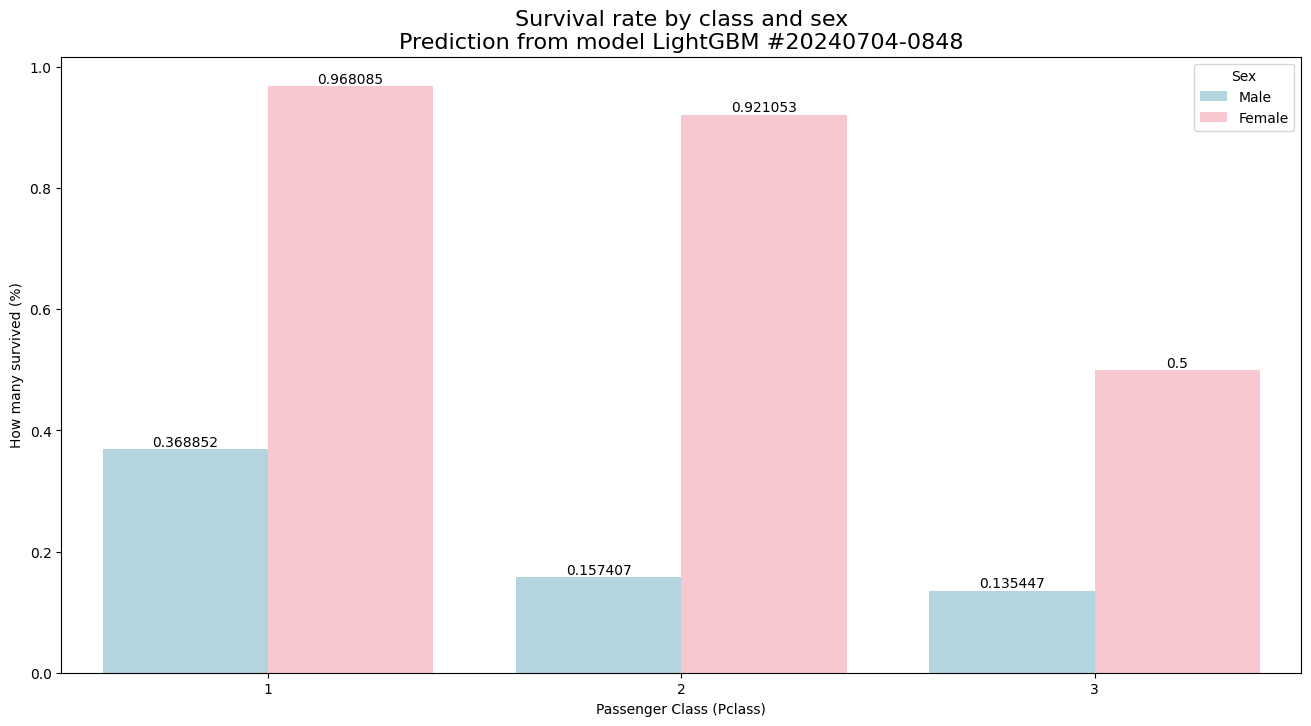

In [189]:
with open("./registros/registros_lgbm.txt", "a") as registros:
    registros.write("########## INÍCIO DE REGISTRO - MODELO LightGBM Classifier " + nome_modelo + " ##########\n")
    registros.write("\nInformações geradas em " + datetime.now().strftime("%d-%m-%Y") + " às " + datetime.now().strftime("%H:%M") + ".\n")
    warnings.filterwarnings("ignore") # inibe os avisos dessa seção, volta ao normal no fim

    # Impostação do resultado obtido
    mask = dados_lgbm['origem'] == 'teste'
    dados_lgbm.loc[mask, 'Survived'] = ypred_lgbm_final

    # Dos dados de Treino
    registros.write('\n---===+++ Predicted and historical ranking comparison +++===---\n')
    registros.write('\nSurvived/perished relationship in *TRAINING* data:\n')

        # Máscaras
    mask1 = dados_lgbm[(dados_lgbm['Pclass'] == 1) & (dados_lgbm['origem'] == 'treino')].index
    mask2 = dados_lgbm[(dados_lgbm['Pclass'] == 2) & (dados_lgbm['origem'] == 'treino')].index
    mask3 = dados_lgbm[(dados_lgbm['Pclass'] == 3) & (dados_lgbm['origem'] == 'treino')].index
    
        # Relação de sobreviventes ou não da 1a classe
    ms1 = (len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Male')])*100)
    md1 = (len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Male')])*100)
    fs1 = (len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Female')])*100)
    fd1 = (len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Female')])*100)

        # Relação de sobreviventes ou não da 2a classe
    ms2 = (len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Male')])*100)
    md2 = (len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Male')])*100)
    fs2 = (len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Female')])*100)
    fd2 = (len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Female')])*100)

        # Relação de sobreviventes ou não da 3a classe
    ms3 = (len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Male')])*100)
    md3 = (len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Male')])*100)
    fs3 = (len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Female')])*100)
    fd3 = (len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Female')])*100)

    registros.write(f'                     PClass1        PClass2        Pclass3\n')
    registros.write(f'Male/Survived...:  {ms1:0>9f}%     {ms2:0>9f}%     {ms3:0>9f}%\n')
    registros.write(f'Male/Perished...:  {md1:0>9f}%     {md2:0>9f}%     {md3:0>9f}%\n')
    registros.write(f'                        *              *              *\n')
    registros.write(f'Female/Survived.:  {fs1:0>9f}%     {fs2:0>9f}%     {fs3:0>9f}%\n')
    registros.write(f'Female/Perished.:  {fd1:0>9f}%     {fd2:0>9f}%     {fd3:0>9f}%\n')

    # Das previsões
    registros.write('\nSurvived/perished relationship in *PREDICTED* data:\n')

    mask1 = dados_lgbm[(dados_lgbm['Pclass'] == 1) & (dados_lgbm['origem'] == 'teste')].index
    mask2 = dados_lgbm[(dados_lgbm['Pclass'] == 2) & (dados_lgbm['origem'] == 'teste')].index
    mask3 = dados_lgbm[(dados_lgbm['Pclass'] == 3) & (dados_lgbm['origem'] == 'teste')].index

        # Relação de sobreviventes ou não da 1a classe
    ms1 = (len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Male')])*100)
    md1 = (len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Male')])*100)
    fs1 = (len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Female')])*100)
    fd1 = (len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask1][(dados_lgbm['Sex'] == 'Female')])*100)

        # Relação de sobreviventes ou não da 2a classe
    ms2 = (len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Male')])*100)
    md2 = (len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Male')])*100)
    fs2 = (len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Female')])*100)
    fd2 = (len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask2][(dados_lgbm['Sex'] == 'Female')])*100)

        # Relação de sobreviventes ou não da 3a classe
    ms3 = (len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Male')])*100)
    md3 = (len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Male') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Male')])*100)
    fs3 = (len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 1)]) / len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Female')])*100)
    fd3 = (len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Female') & (dados_lgbm['Survived'] == 0)]) / len(dados_lgbm.loc[mask3][(dados_lgbm['Sex'] == 'Female')])*100)


    registros.write(f'                     PClass1        PClass2        Pclass3\n')
    registros.write(f'Male/Survived...:  {ms1:0>9f}%     {ms2:0>9f}%     {ms3:0>9f}%\n')
    registros.write(f'Male/Perished...:  {md1:0>9f}%     {md2:0>9f}%     {md3:0>9f}%\n')
    registros.write(f'                        *              *              *\n')
    registros.write(f'Female/Survived.:  {fs1:0>9f}%     {fs2:0>9f}%     {fs3:0>9f}%\n')
    registros.write(f'Female/Perished.:  {fd1:0>9f}%     {fd2:0>9f}%     {fd3:0>9f}%\n')

    # Prints the predictions graph
    ext_graph = (".png")
    name_graph = ("previsoes_lgbmClassifier_"+(nome_modelo + ext_graph))
    plt.figure(figsize =(16, 8))
    sns.color_palette("pastel")
    graph = sns.barplot(data=dados_lgbm[dados_lgbm['origem'] == 'treino'], x='Pclass', y='Survived', hue = 'Sex', hue_order = ['Male', 'Female'], palette = paleta, errorbar = None)
    graph.bar_label(graph.containers[0], fontsize=10)
    graph.bar_label(graph.containers[1], fontsize=10)
    plt.ylabel("How many survived (%)")
    plt.xlabel('Passenger Class (Pclass)')
    plt.title(f'Survival rate by class and sex\nPrediction from model LightGBM #{nome_modelo}', fontsize = 16)
    fig = graph.get_figure()
    fig.savefig('./imagens/'+name_graph)

    registros.write("\nFeatures que foram utilizadas no modelo e que tiveram relevância no algoritmo:\n")
    importancias = pd.DataFrame(classif_lgbm.feature_importances_, classif_lgbm.feature_name_)
    importancias.reset_index(inplace = True)
    importancias.columns = ["variável", "importância"]
    registros.write(str(importancias[importancias['importância'] > 0].sort_values(by = "importância", ascending = False)))
    if discard_index.sum() > 0:
        registros.write("\n\nFeatures sem importância:"+ str(dados_treino.columns.values[discard_index]) + ".\n")
    else: registros.write("\n\nNão foram identificadas features sem importância.\n")

    registros.write(f'\nCoeficiente de Determinação R2: {score_lgbm_r2:.6f}\n')
    registros.write(f'Score de validação cruzada: {cv_scores_lgbm.mean():.6f}\n\n')

    if dados_lgbm.Fare.max() > 300: registros.write("Outliers em 'Fare' identificados.\n")
    else: registros.write("Não foram identificados outliers (somente 'Fare' é passível de ter outliers).\n")


    registros.write("\nParâmetros do modelo:\n")
    registros.write(str(classif_lgbm.get_params()))
    registros.write("\n\n=======================================================================\n\n\n")

## RandomForestClassifier (sklearn)

### Modelo

In [190]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Estabelecimento do nome do modelo para fins de registro
nome_modelo = datetime.now().strftime("%Y%m%d-%H%M")

classif_skl_rf = RandomForestClassifier(n_estimators = 1600,
                                        criterion = 'entropy', # 'gini' default, 'entropy', 'log_loss'
                                        max_depth = 21, # default None
                                        min_samples_split = 6, # default 2
                                        min_samples_leaf = 1, # default 1
                                        max_features='sqrt', # 'sqrt' default, 'log2, None
                                        bootstrap = True, # se 'False' usa o dataset inteiro para montar cada árvore
                                        oob_score = False, # Utilizado se bootstrep = True, usa uma métrica para o score geral (algo tipo r2score(y_true, y_pred))
                                        max_samples = 0.4, # usa com bootstrap = True, percentual de utilização amostral de X para treinar cada estimamdor
                                        n_jobs = 12,
                                        random_state = 1,
                                        verbose = 2,
                                        warm_start = False, # default, se True reutiliza a solução do último fit e adiciona mais estimadores ao agrupado
                                        )

verif_outliers()

classif_skl_rf.fit(treino_x, treino_y)

ypred_skl_rf = classif_skl_rf.predict(teste_x)
score_skl_rf = r2_score(teste_y, ypred_skl_rf)

cv_scores_skl_rf = cross_val_score(classif_skl_rf, treino_x, y = treino_y, # estimador (usado no fit), X, y (se existente)
                                       cv = 5, # None: default 5-fold cross validation
                                       n_jobs = 12,
                                       verbose = 0,
                                       error_score = 'raise')


discard_index = classif_skl_rf.feature_importances_ == 0
print(f'\nCoeficiente de determinação: {score_skl_rf:.6f}')
print(f'Score de validação cruzada: {cv_scores_skl_rf.mean():.6f}')

# Verifica a existência de variáveis desprezíveis utilizadas na modelagem
if discard_index.sum() > 0:
    print("\nATENÇÃO! Variáveis sem importância encontradas!")
    print("\nPodem ser descartadas as variáveis: ", dados_treino.columns.values[discard_index])
else: print("\nTodas variáveis utilizadas, nenhuma sem importância.")

Não foram identificados outliers (somente 'Fare' é passível de ter outliers).



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s


building tree 1 of 1600
building tree 2 of 1600
building tree 3 of 1600
building tree 4 of 1600
building tree 5 of 1600
building tree 6 of 1600
building tree 7 of 1600
building tree 8 of 1600
building tree 9 of 1600
building tree 10 of 1600
building tree 11 of 1600
building tree 12 of 1600
building tree 13 of 1600
building tree 14 of 1600
building tree 15 of 1600
building tree 16 of 1600
building tree 17 of 1600
building tree 18 of 1600
building tree 19 of 1600
building tree 20 of 1600
building tree 21 of 1600
building tree 22 of 1600
building tree 23 of 1600
building tree 24 of 1600
building tree 25 of 1600
building tree 26 of 1600
building tree 27 of 1600
building tree 28 of 1600
building tree 29 of 1600
building tree 30 of 1600
building tree 31 of 1600
building tree 32 of 1600
building tree 33 of 1600
building tree 34 of 1600
building tree 35 of 1600
building tree 36 of 1600
building tree 37 of 1600
building tree 38 of 1600
building tree 39 of 1600
building tree 40 of 1600
building 

[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.4s


building tree 159 of 1600
building tree 160 of 1600
building tree 161 of 1600
building tree 162 of 1600
building tree 163 of 1600
building tree 164 of 1600
building tree 165 of 1600
building tree 166 of 1600
building tree 167 of 1600
building tree 168 of 1600
building tree 169 of 1600
building tree 170 of 1600
building tree 171 of 1600
building tree 172 of 1600
building tree 173 of 1600
building tree 174 of 1600
building tree 175 of 1600
building tree 176 of 1600
building tree 177 of 1600
building tree 178 of 1600
building tree 179 of 1600
building tree 180 of 1600
building tree 181 of 1600
building tree 182 of 1600
building tree 183 of 1600
building tree 184 of 1600
building tree 185 of 1600
building tree 186 of 1600
building tree 187 of 1600
building tree 188 of 1600
building tree 189 of 1600
building tree 190 of 1600
building tree 191 of 1600
building tree 192 of 1600
building tree 193 of 1600
building tree 194 of 1600
building tree 195 of 1600
building tree 196 of 1600
building tre

[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.0s


building tree 387 of 1600
building tree 388 of 1600
building tree 389 of 1600
building tree 390 of 1600
building tree 391 of 1600
building tree 392 of 1600
building tree 393 of 1600
building tree 394 of 1600
building tree 395 of 1600
building tree 396 of 1600
building tree 397 of 1600
building tree 398 of 1600
building tree 399 of 1600
building tree 400 of 1600
building tree 401 of 1600
building tree 402 of 1600
building tree 403 of 1600
building tree 404 of 1600
building tree 405 of 1600
building tree 406 of 1600
building tree 407 of 1600
building tree 408 of 1600
building tree 409 of 1600
building tree 410 of 1600
building tree 411 of 1600
building tree 412 of 1600
building tree 413 of 1600
building tree 414 of 1600
building tree 415 of 1600
building tree 416 of 1600
building tree 417 of 1600
building tree 418 of 1600
building tree 419 of 1600
building tree 420 of 1600
building tree 421 of 1600
building tree 422 of 1600
building tree 423 of 1600
building tree 424 of 1600
building tre

[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    1.9s


building tree 671 of 1600
building tree 672 of 1600
building tree 673 of 1600
building tree 674 of 1600
building tree 675 of 1600
building tree 676 of 1600
building tree 677 of 1600
building tree 678 of 1600
building tree 679 of 1600
building tree 680 of 1600
building tree 681 of 1600
building tree 682 of 1600
building tree 683 of 1600
building tree 684 of 1600
building tree 685 of 1600
building tree 686 of 1600
building tree 687 of 1600
building tree 688 of 1600
building tree 689 of 1600
building tree 690 of 1600
building tree 691 of 1600
building tree 692 of 1600
building tree 693 of 1600
building tree 694 of 1600
building tree 695 of 1600
building tree 696 of 1600
building tree 697 of 1600
building tree 698 of 1600
building tree 699 of 1600
building tree 700 of 1600
building tree 701 of 1600
building tree 702 of 1600
building tree 703 of 1600
building tree 704 of 1600
building tree 705 of 1600
building tree 706 of 1600
building tree 707 of 1600
building tree 708 of 1600
building tre

[Parallel(n_jobs=12)]: Done 989 tasks      | elapsed:    3.0s


building tree 1041 of 1600
building tree 1042 of 1600
building tree 1043 of 1600
building tree 1044 of 1600
building tree 1045 of 1600
building tree 1046 of 1600
building tree 1047 of 1600
building tree 1048 of 1600
building tree 1049 of 1600
building tree 1050 of 1600
building tree 1051 of 1600
building tree 1052 of 1600
building tree 1053 of 1600
building tree 1054 of 1600
building tree 1055 of 1600
building tree 1056 of 1600
building tree 1057 of 1600
building tree 1058 of 1600
building tree 1059 of 1600
building tree 1060 of 1600
building tree 1061 of 1600
building tree 1062 of 1600
building tree 1063 of 1600
building tree 1064 of 1600
building tree 1065 of 1600
building tree 1066 of 1600
building tree 1067 of 1600
building tree 1068 of 1600
building tree 1069 of 1600
building tree 1070 of 1600
building tree 1071 of 1600
building tree 1072 of 1600
building tree 1073 of 1600
building tree 1074 of 1600
building tree 1075 of 1600
building tree 1076 of 1600
building tree 1077 of 1600
b

[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed:    4.1s


building tree 1490 of 1600building tree 1491 of 1600
building tree 1492 of 1600
building tree 1493 of 1600
building tree 1494 of 1600
building tree 1495 of 1600

building tree 1496 of 1600
building tree 1497 of 1600
building tree 1498 of 1600
building tree 1499 of 1600
building tree 1500 of 1600
building tree 1501 of 1600
building tree 1502 of 1600
building tree 1503 of 1600
building tree 1504 of 1600
building tree 1505 of 1600
building tree 1506 of 1600
building tree 1507 of 1600
building tree 1508 of 1600
building tree 1509 of 1600
building tree 1510 of 1600
building tree 1511 of 1600
building tree 1512 of 1600
building tree 1513 of 1600
building tree 1514 of 1600
building tree 1515 of 1600
building tree 1516 of 1600
building tree 1517 of 1600
building tree 1518 of 1600
building tree 1519 of 1600
building tree 1520 of 1600
building tree 1521 of 1600
building tree 1522 of 1600
building tree 1523 of 1600
building tree 1524 of 1600
building tree 1525 of 1600
building tree 1526 of 1600
b

[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    4.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 989 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    0.4s finished
/home/thiago/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/thiago/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning:

building tree 1 of 1600building tree 2 of 1600

building tree 3 of 1600building tree 4 of 1600
building tree 5 of 1600
building tree 6 of 1600
building tree 7 of 1600

building tree 8 of 1600
building tree 9 of 1600
building tree 10 of 1600
building tree 11 of 1600
building tree 12 of 1600
building tree 13 of 1600
building tree 14 of 1600
building tree 15 of 1600
building tree 16 of 1600
building tree 17 of 1600
building tree 18 of 1600
building tree 19 of 1600
building tree 20 of 1600
building tree 21 of 1600
building tree 22 of 1600
building tree 23 of 1600building tree 24 of 1600
building tree 25 of 1600building tree 26 of 1600
building tree 27 of 1600

building tree 28 of 1600
building tree 29 of 1600

building tree 30 of 1600
building tree 31 of 1600
building tree 32 of 1600
building tree 33 of 1600
building tree 34 of 1600
building tree 35 of 1600
building tree 36 of 1600
building tree 37 of 1600building tree 38 of 1600
building tree 39 of 1600
building tree 40 of 1600
building t

[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.3s
/home/thiago/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.2s


 186 of 1600
building tree 187 of 1600
building tree 188 of 1600building tree 189 of 1600
building tree 190 of 1600
building tree 191 of 1600
building tree 192 of 1600
building tree 193 of 1600

building tree 194 of 1600
building tree 195 of 1600
building tree 196 of 1600
building tree 197 of 1600
building tree 198 of 1600
building tree 199 of 1600
building tree 200 of 1600
building tree 201 of 1600
building tree 202 of 1600
building tree 203 of 1600
building tree 204 of 1600
building tree 205 of 1600
building tree 206 of 1600
building tree 207 of 1600
building tree 208 of 1600
building tree 209 of 1600
building tree 210 of 1600
building tree 211 of 1600
building tree 212 of 1600
building tree 213 of 1600building tree 214 of 1600
building tree 215 of 1600

building tree 216 of 1600
building tree 217 of 1600
building tree 218 of 1600
building tree 219 of 1600
building tree 220 of 1600
building tree 221 of 1600
building tree 222 of 1600
building tree 223 of 1600
building tree 224 of 1600

[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.6s
/home/thiago/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    1.0s


building tree 663 of 1600
building tree 232 of 1600
building tree 664 of 1600
building tree 233 of 1600
building tree 887 of 1600
building tree 665 of 1600
building tree 234 of 1600
building tree 888 of 1600
building tree 235 of 1600
building tree 889 of 1600
building tree 666 of 1600
building tree 890 of 1600
building tree 891 of 1600
building tree 667 of 1600
building tree 236 of 1600building tree 237 of 1600
building tree 668 of 1600
building tree 238 of 1600
building tree 669 of 1600
building tree 239 of 1600

building tree 892 of 1600
building tree 240 of 1600
building tree 670 of 1600
building tree 241 of 1600
building tree 671 of 1600
building tree 242 of 1600
building tree 243 of 1600
building tree 893 of 1600
building tree 672 of 1600
building tree 244 of 1600
building tree 894 of 1600
building tree 895 of 1600
building tree 896 of 1600
building tree 897 of 1600
building tree 673 of 1600
building tree 245 of 1600
building tree 674 of 1600
building tree 675 of 1600
building tre

[Parallel(n_jobs=12)]: Done 989 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.6s
/home/thiago/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


building tree 790 of 1600
building tree 1010 of 1600
building tree 1011 of 1600
building tree 355 of 1600
building tree 791 of 1600
building tree 356 of 1600
building tree 357 of 1600
building tree 1012 of 1600
building tree 1013 of 1600
building tree 792 of 1600
building tree 358 of 1600
building tree 359 of 1600
building tree 1014 of 1600
building tree 793 of 1600
building tree 360 of 1600
building tree 1015 of 1600
building tree 1016 of 1600
building tree 794 of 1600
building tree 361 of 1600
building tree 795 of 1600
building tree 1017 of 1600
building tree 362 of 1600
building tree 796 of 1600
building tree 1018 of 1600
building tree 797 of 1600
building tree 363 of 1600building tree 364 of 1600

building tree 798 of 1600building tree 1019 of 1600
building tree 799 of 1600

building tree 800 of 1600
building tree 1020 of 1600
building tree 365 of 1600
building tree 801 of 1600
building tree 1021 of 1600
building tree 366 of 1600
building tree 802 of 1600
building tree 1022 of 1600

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 989 tasks      | elapsed:    1.6s


building tree 593 of 1600
building tree 594 of 1600
building tree 1030 of 1600building tree 1249 of 1600

building tree 103 of 1600
building tree 1031 of 1600
building tree 1250 of 1600
building tree 104 of 1600
building tree 595 of 1600
building tree 1032 of 1600
building tree 1251 of 1600
building tree 105 of 1600
building tree 1033 of 1600
building tree 1252 of 1600
building tree 1253 of 1600
building tree 1034 of 1600building tree 1035 of 1600
building tree 596 of 1600
building tree 597 of 1600
building tree 1036 of 1600
building tree 598 of 1600
building tree 599 of 1600
building tree 106 of 1600
building tree 107 of 1600
building tree 1254 of 1600
building tree 1255 of 1600
building tree 108 of 1600
building tree 1037 of 1600

building tree 109 of 1600
building tree 600 of 1600
building tree 1038 of 1600
building tree 601 of 1600
building tree 1256 of 1600
building tree 1257 of 1600
building tree 1258 of 1600
building tree 110 of 1600building tree 1039 of 1600
building tree 1040 

[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    1.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.3s


building tree 1367 of 1600
building tree 1368 of 1600
building tree 711 of 1600building tree 712 of 1600
building tree 1149 of 1600
building tree 1150 of 1600
building tree 1151 of 1600
building tree 226 of 1600
building tree 1369 of 1600
building tree 1370 of 1600
building tree 227 of 1600
building tree 1152 of 1600
building tree 1371 of 1600
building tree 228 of 1600building tree 713 of 1600
building tree 1153 of 1600
building tree 229 of 1600

building tree 714 of 1600
building tree 1154 of 1600
building tree 230 of 1600
building tree 1155 of 1600
building tree 1372 of 1600
building tree 1373 of 1600
building tree 231 of 1600
building tree 715 of 1600
building tree 716 of 1600
building tree 717 of 1600
building tree 1156 of 1600
building tree 718 of 1600
building tree 1157 of 1600
building tree 232 of 1600
building tree 1158 of 1600
building tree 233 of 1600building tree 719 of 1600
building tree 1374 of 1600
building tree 1375 of 1600
building tree 1376 of 1600
building tree 1377 o

[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed:    2.5s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s


building tree 1273 of 1600
building tree 831 of 1600
building tree 343 of 1600
building tree 1274 of 1600
building tree 832 of 1600
building tree 344 of 1600
building tree 1483 of 1600
building tree 345 of 1600
building tree 1484 of 1600
building tree 1275 of 1600
building tree 346 of 1600
building tree 347 of 1600
building tree 833 of 1600
building tree 834 of 1600
building tree 1485 of 1600
building tree 1276 of 1600
building tree 835 of 1600
building tree 348 of 1600
building tree 1486 of 1600
building tree 349 of 1600
building tree 836 of 1600
building tree 1277 of 1600
building tree 1487 of 1600
building tree 837 of 1600
building tree 1278 of 1600
building tree 1488 of 1600
building tree 1279 of 1600
building tree 1489 of 1600
building tree 1280 of 1600
building tree 838 of 1600
building tree 839 of 1600
building tree 350 of 1600
building tree 1281 of 1600
building tree 351 of 1600
building tree 1282 of 1600
building tree 840 of 1600
building tree 352 of 1600
building tree 1490 of

[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    2.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 989 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed:    2.4s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 989 tasks      | elapsed:    0.2s


building tree 559 of 1600
building tree 560 of 1600building tree 1049 of 1600
building tree 185 of 1600
building tree 1488 of 1600
building tree 1050 of 1600building tree 186 of 1600
building tree 561 of 1600
building tree 1051 of 1600


building tree 1489 of 1600
building tree 562 of 1600
building tree 1052 of 1600
building tree 563 of 1600
building tree 187 of 1600
building tree 188 of 1600building tree 564 of 1600
building tree 189 of 1600
building tree 1490 of 1600
building tree 1053 of 1600
building tree 1491 of 1600


building tree 1054 of 1600
building tree 565 of 1600
building tree 1492 of 1600

building tree 190 of 1600
building tree 1055 of 1600
building tree 566 of 1600
building tree 191 of 1600building tree 1493 of 1600building tree 192 of 1600
building tree 193 of 1600
building tree 1056 of 1600
building tree 1057 of 1600
building tree 1494 of 1600
building tree 194 of 1600
building tree 567 of 1600
building tree 1495 of 1600
building tree 195 of 1600
building tree 1496 of

[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    1.1s
[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    2.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.6s


building tree 1170 of 1600
building tree 1171 of 1600
building tree 300 of 1600
building tree 1172 of 1600building tree 1173 of 1600
building tree 679 of 1600
building tree 301 of 1600
building tree 680 of 1600building tree 302 of 1600
building tree 1174 of 1600
building tree 681 of 1600building tree 682 of 1600
building tree 303 of 1600
building tree 683 of 1600
building tree 1175 of 1600
building tree 304 of 1600
building tree 305 of 1600
building tree 1176 of 1600
building tree 684 of 1600
building tree 306 of 1600

building tree 685 of 1600
building tree 307 of 1600

building tree 308 of 1600
building tree 1177 of 1600

building tree 1178 of 1600
building tree 686 of 1600
building tree 309 of 1600
building tree 310 of 1600
building tree 687 of 1600
building tree 688 of 1600
building tree 1179 of 1600
building tree 1180 of 1600
building tree 689 of 1600
building tree 1181 of 1600
building tree 311 of 1600
building tree 312 of 1600
building tree 690 of 1600
building tree 1182 of 1600

[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 989 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    0.3s finished


building tree 1298 of 1600
building tree 1299 of 1600
building tree 424 of 1600
building tree 804 of 1600
building tree 1300 of 1600
building tree 805 of 1600building tree 1301 of 1600
building tree 425 of 1600

building tree 426 of 1600
building tree 1302 of 1600building tree 806 of 1600
building tree 807 of 1600
building tree 1303 of 1600

building tree 1304 of 1600
building tree 427 of 1600
building tree 428 of 1600
building tree 429 of 1600
building tree 1305 of 1600
building tree 808 of 1600
building tree 809 of 1600building tree 1306 of 1600

building tree 430 of 1600
building tree 431 of 1600
building tree 810 of 1600
building tree 811 of 1600
building tree 812 of 1600
building tree 1307 of 1600
building tree 432 of 1600building tree 433 of 1600
building tree 1308 of 1600
building tree 813 of 1600
building tree 1309 of 1600
building tree 434 of 1600
building tree 814 of 1600
building tree 435 of 1600
building tree 1310 of 1600
building tree 1311 of 1600
building tree 815 of 1600

[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed:    2.4s
[Parallel(n_jobs=12)]: Done 989 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    1.1s


building tree 685 of 1600
building tree 1074 of 1600
building tree 1075 of 1600
building tree 1566 of 1600
building tree 1567 of 1600
building tree 686 of 1600
building tree 687 of 1600
building tree 1076 of 1600building tree 1568 of 1600
building tree 1077 of 1600
building tree 688 of 1600
building tree 1078 of 1600
building tree 1569 of 1600
building tree 1570 of 1600
building tree 1079 of 1600
building tree 1571 of 1600
building tree 1572 of 1600
building tree 689 of 1600
building tree 690 of 1600building tree 1080 of 1600

building tree 691 of 1600
building tree 1081 of 1600

building tree 1573 of 1600building tree 1574 of 1600
building tree 692 of 1600
building tree 1082 of 1600
building tree 1083 of 1600
building tree 1575 of 1600
building tree 693 of 1600
building tree 1576 of 1600
building tree 1577 of 1600
building tree 1084 of 1600
building tree 1085 of 1600

building tree 694 of 1600
building tree 1578 of 1600
building tree 1086 of 1600
building tree 1579 of 1600
building tr

[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    2.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 989 tasks      | elapsed:    0.2s


building tree 1209 of 1600
building tree 821 of 1600
building tree 1210 of 1600
building tree 822 of 1600
building tree 1211 of 1600
building tree 823 of 1600
building tree 1212 of 1600
building tree 824 of 1600
building tree 825 of 1600
building tree 826 of 1600
building tree 827 of 1600
building tree 1213 of 1600
building tree 1214 of 1600
building tree 828 of 1600
building tree 1215 of 1600
building tree 1216 of 1600
building tree 829 of 1600
building tree 830 of 1600
building tree 831 of 1600
building tree 1217 of 1600
building tree 832 of 1600
building tree 833 of 1600
building tree 1218 of 1600
building tree 1219 of 1600
building tree 1220 of 1600
building tree 1221 of 1600
building tree 1222 of 1600building tree 834 of 1600

building tree 1223 of 1600
building tree 1224 of 1600
building tree 835 of 1600
building tree 836 of 1600
building tree 1225 of 1600
building tree 837 of 1600
building tree 838 of 1600
building tree 839 of 1600
building tree 1226 of 1600
building tree 1227 o

[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    0.3s finished


building tree 951 of 1600
building tree 1347 of 1600
building tree 952 of 1600
building tree 1348 of 1600
building tree 1349 of 1600
building tree 1350 of 1600
building tree 953 of 1600
building tree 954 of 1600
building tree 955 of 1600building tree 956 of 1600
building tree 1351 of 1600
building tree 1352 of 1600
building tree 1353 of 1600
building tree 957 of 1600building tree 958 of 1600
building tree 1354 of 1600building tree 959 of 1600
building tree 1355 of 1600
building tree 1356 of 1600
building tree 1357 of 1600
building tree 1358 of 1600
building tree 1359 of 1600


building tree 960 of 1600
building tree 1360 of 1600
building tree 961 of 1600

building tree 1361 of 1600
building tree 962 of 1600
building tree 1362 of 1600
building tree 1363 of 1600
building tree 1364 of 1600
building tree 1365 of 1600
building tree 963 of 1600
building tree 964 of 1600
building tree 1366 of 1600
building tree 965 of 1600building tree 966 of 1600
building tree 1367 of 1600
building tree 1368

[Parallel(n_jobs=12)]: Done 989 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed:    2.3s


building tree 1049 of 1600
building tree 1050 of 1600
building tree 1492 of 1600
building tree 1493 of 1600
building tree 1051 of 1600
building tree 1494 of 1600
building tree 1495 of 1600
building tree 1052 of 1600building tree 1496 of 1600
building tree 1497 of 1600
building tree 1053 of 1600
building tree 1498 of 1600
building tree 1054 of 1600

building tree 1055 of 1600
building tree 1499 of 1600
building tree 1500 of 1600
building tree 1056 of 1600building tree 1501 of 1600
building tree 1057 of 1600building tree 1058 of 1600building tree 1502 of 1600
building tree 1059 of 1600

building tree 1503 of 1600
building tree 1060 of 1600
building tree 1504 of 1600

building tree 1061 of 1600building tree 1505 of 1600
building tree 1062 of 1600
building tree 1506 of 1600

building tree 1507 of 1600
building tree 1508 of 1600
building tree 1063 of 1600
building tree 1509 of 1600
building tree 1510 of 1600
building tree 1511 of 1600
building tree 1064 of 1600
building tree 1512 of 1600
bu

[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    2.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 989 tasks      | elapsed:    0.2s


building tree 1148 of 1600
building tree 1149 of 1600building tree 1150 of 1600
building tree 1151 of 1600
building tree 1152 of 1600
building tree 1153 of 1600

building tree 1154 of 1600
building tree 1155 of 1600
building tree 1156 of 1600
building tree 1157 of 1600
building tree 1158 of 1600
building tree 1159 of 1600building tree 1160 of 1600
building tree 1161 of 1600
building tree 1162 of 1600

building tree 1163 of 1600
building tree 1164 of 1600
building tree 1165 of 1600
building tree 1166 of 1600
building tree 1167 of 1600
building tree 1168 of 1600
building tree 1169 of 1600
building tree 1170 of 1600
building tree 1171 of 1600
building tree 1172 of 1600
building tree 1173 of 1600
building tree 1174 of 1600
building tree 1175 of 1600
building tree 1176 of 1600
building tree 1177 of 1600
building tree 1178 of 1600
building tree 1179 of 1600
building tree 1180 of 1600
building tree 1181 of 1600
building tree 1182 of 1600
building tree 1183 of 1600
building tree 1184 of 1600
b

[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    0.3s finished


building tree 1374 of 1600
building tree 1375 of 1600
building tree 1376 of 1600
building tree 1377 of 1600
building tree 1378 of 1600
building tree 1379 of 1600
building tree 1380 of 1600
building tree 1381 of 1600building tree 1382 of 1600
building tree 1383 of 1600building tree 1384 of 1600

building tree 1385 of 1600

building tree 1386 of 1600building tree 1387 of 1600
building tree 1388 of 1600
building tree 1389 of 1600
building tree 1390 of 1600
building tree 1391 of 1600

building tree 1392 of 1600
building tree 1393 of 1600
building tree 1394 of 1600
building tree 1395 of 1600
building tree 1396 of 1600building tree 1397 of 1600

building tree 1398 of 1600
building tree 1399 of 1600
building tree 1400 of 1600
building tree 1401 of 1600
building tree 1402 of 1600building tree 1403 of 1600

building tree 1404 of 1600
building tree 1405 of 1600building tree 1406 of 1600
building tree 1407 of 1600
building tree 1408 of 1600
building tree 1409 of 1600

building tree 1410 of 1600
b

[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed:    2.5s


building tree 1463 of 1600

building tree 1464 of 1600
building tree 1465 of 1600
building tree 1466 of 1600
building tree 1467 of 1600
building tree 1468 of 1600
building tree 1469 of 1600
building tree 1470 of 1600
building tree 1471 of 1600
building tree 1472 of 1600
building tree 1473 of 1600
building tree 1474 of 1600building tree 1475 of 1600

building tree 1476 of 1600
building tree 1477 of 1600
building tree 1478 of 1600
building tree 1479 of 1600
building tree 1480 of 1600
building tree 1481 of 1600
building tree 1482 of 1600building tree 1483 of 1600
building tree 1484 of 1600

building tree 1485 of 1600
building tree 1486 of 1600
building tree 1487 of 1600
building tree 1488 of 1600
building tree 1489 of 1600
building tree 1490 of 1600
building tree 1491 of 1600
building tree 1492 of 1600
building tree 1493 of 1600
building tree 1494 of 1600
building tree 1495 of 1600
building tree 1496 of 1600
building tree 1497 of 1600
building tree 1498 of 1600
building tree 1499 of 1600


[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    2.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 989 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    0.5s finished



Coeficiente de determinação: 0.132184
Score de validação cruzada: 0.826171

ATENÇÃO! Variáveis sem importância encontradas!

Podem ser descartadas as variáveis:  ['Title_Dona' 'Title_Jonkheer' 'Title_Mlle' 'Title_Mme' 'Title_Ms'
 'Title_the Countess']


### Optuna

In [191]:
"""
# Define a função que vai testar os hiperparâmetros
def objective(testar):
    n_estimators = testar.suggest_int('n_estimators', 100, 2500, step = 100)
    criterion = testar.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = testar.suggest_int('max_depth', 2, 30), # está certo na documentação, mas por algum motivo não aceita int
    min_samples_split = testar.suggest_int('min_samples_split', 2, 64, step = 4)
    min_samples_leaf = testar.suggest_int('min_samples_leaf', 1, 8)
    max_features = testar.suggest_categorical('max_features', ['sqrt', 'log2', None])
    max_samples = testar.suggest_float('max_samples', 0.1, 1.0, step = 0.1)
    warm_start = testar.suggest_categorical('warm_start', [False, True])
    
    classif_skl_rf = RandomForestClassifier(n_estimators = n_estimators,
                                        criterion = criterion,
                                        max_depth = None,
                                        min_samples_split = min_samples_split,
                                        min_samples_leaf = min_samples_leaf,
                                        max_features = max_features,
                                        bootstrap = True,
                                        max_samples = max_samples,
                                        n_jobs = 12,
                                        random_state = 1,
                                        verbose = 2,
                                        warm_start = warm_start
                                        )

    classif_skl_rf.fit(treino_x, treino_y)

    cv_scores_skl_rf = cross_val_score(classif_skl_rf, treino_x, y = treino_y, # estimador (usado no fit), X, y (se existente)
                                       cv = 5, # None: default 5-fold cross validation
                                       n_jobs = 12,
                                       verbose = 0,
                                       error_score = 'raise')
    return cv_scores_skl_rf.mean()

# Cria o objeto de estudo dos parâmetros
optuna_skrf = optuna.create_study(direction = 'maximize',
                                 sampler = optuna.samplers.RandomSampler(seed = 1))

# Começa a realizar os testes de iteração
warnings.filterwarnings("ignore") # inibe os avisos dessa seção, volta ao normal no fim
optuna_skrf.optimize(objective, n_trials= 500)
warnings.filterwarnings("default")

# Armazena os melhores parâmetros em um objeto
melhores_optuna_skrf = optuna_skrf.best_params
"""

'\n# Define a função que vai testar os hiperparâmetros\ndef objective(testar):\n    n_estimators = testar.suggest_int(\'n_estimators\', 100, 2500, step = 100)\n    criterion = testar.suggest_categorical(\'criterion\', [\'gini\', \'entropy\', \'log_loss\'])\n    max_depth = testar.suggest_int(\'max_depth\', 2, 30), # está certo na documentação, mas por algum motivo não aceita int\n    min_samples_split = testar.suggest_int(\'min_samples_split\', 2, 64, step = 4)\n    min_samples_leaf = testar.suggest_int(\'min_samples_leaf\', 1, 8)\n    max_features = testar.suggest_categorical(\'max_features\', [\'sqrt\', \'log2\', None])\n    max_samples = testar.suggest_float(\'max_samples\', 0.1, 1.0, step = 0.1)\n    warm_start = testar.suggest_categorical(\'warm_start\', [False, True])\n    \n    classif_skl_rf = RandomForestClassifier(n_estimators = n_estimators,\n                                        criterion = criterion,\n                                        max_depth = None,\n           

In [192]:
# Gráficos diversos sobre o estudo realizado
#optuna.visualization.plot_optimization_history(optuna_skrf)

#optuna.visualization.plot_param_importances(optuna_skrf)

#optuna.visualization.plot_parallel_coordinate(optuna_skrf)

#optuna.visualization.plot_slice(optuna_skrf, params = ['loss', 'n_estimators', 'learning_rate', 'criterion', 'min_samples_split', 'min_samples_leaf', 'max_depth', 'subsample'])

In [193]:
"""
# Realiza o registro em arquivo texto para posterior consulta
with open("./registros/optuna_sklearn-randomforest.txt", "a") as registros:
    registros.write("########## INÍCIO DE REGISTRO OPTUNA - MODELO Sklearn RandomForest ##########\n")
    registros.write("\nInformações armazenadas em " + datetime.now().strftime("%d-%m-%Y") + " às " + datetime.now().strftime("%H:%M") + ".\n")
    
    registros.write('\n---===+++ Os melhores parâmetros encontrados +++===---\n\n')
    registros.write(str(melhores_optuna_skrf))
    registros.write(f'\n\nObtidos na iteração {optuna_skrf.best_trial.number}\n')
    registros.write(f'Valor de score cross-validation {optuna_skrf.best_value}\n\n')
    registros.write("########## FINAL DE REGISTRO OPTUNA - MODELO Sklearn RandomForest ##########\n\n\n")
"""

'\n# Realiza o registro em arquivo texto para posterior consulta\nwith open("./registros/optuna_sklearn-randomforest.txt", "a") as registros:\n    registros.write("########## INÍCIO DE REGISTRO OPTUNA - MODELO Sklearn RandomForest ##########\n")\n    registros.write("\nInformações armazenadas em " + datetime.now().strftime("%d-%m-%Y") + " às " + datetime.now().strftime("%H:%M") + ".\n")\n    \n    registros.write(\'\n---===+++ Os melhores parâmetros encontrados +++===---\n\n\')\n    registros.write(str(melhores_optuna_skrf))\n    registros.write(f\'\n\nObtidos na iteração {optuna_skrf.best_trial.number}\n\')\n    registros.write(f\'Valor de score cross-validation {optuna_skrf.best_value}\n\n\')\n    registros.write("########## FINAL DE REGISTRO OPTUNA - MODELO Sklearn RandomForest ##########\n\n\n")\n'

### Previsão do modelo e geração do arquivo de submissão

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 989 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 1600 out of 1600 | elapsed:    0.5s finished




###### MODELO Sklearn RandomForest 20240704-0849 ######

Informações geradas em 04-07-2024 às 08:49.

Coeficiente de Determinação R2: 0.132184
Score de validação cruzada: 0.826171

---===+++ Predicted and historical ranking comparison +++===---

Survived/perished relationship in TRAINING data:
                     PClass1        PClass2        Pclass3
Male/Survived...:  36.885246%     15.740741%     13.544669%
Male/Perished...:  63.114754%     84.259259%     86.455331%
                        *              *              *
Female/Survived.:  96.808511%     92.105263%     50.000000%
Female/Perished.:  03.191489%     07.894737%     50.000000%


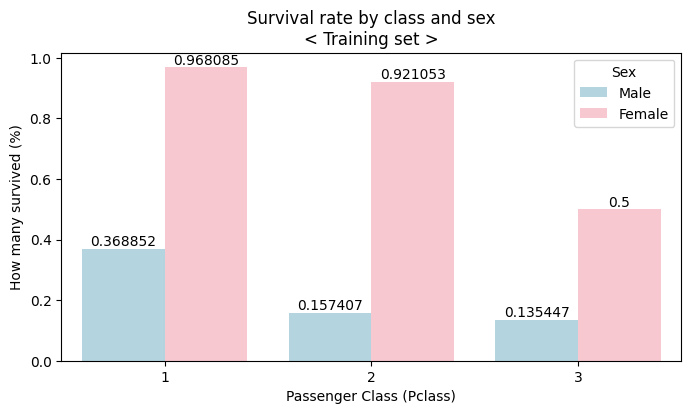

Survived/perished relationship in PREDICTED data:
                     PClass1        PClass2        Pclass3
Male/Survived...:  36.842105%     06.349206%     07.534247%
Male/Perished...:  63.157895%     93.650794%     92.465753%
                        *              *              *
Female/Survived.:  100.000000%     100.000000%     63.888889%
Female/Perished.:  00.000000%     00.000000%     36.111111%


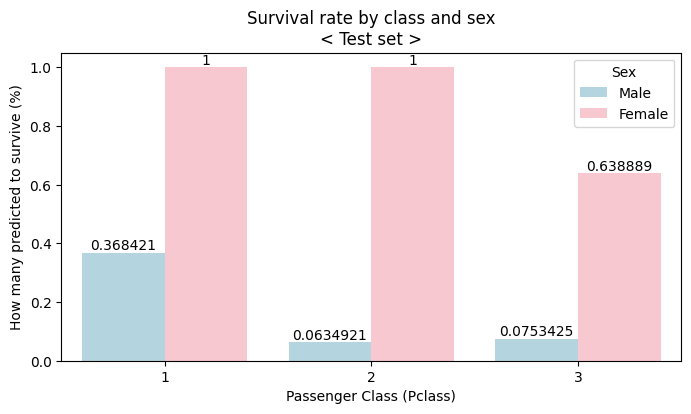


Features que foram utilizadas no modelo e que tiveram relevância no algoritmo:
        variável  importância
0            Age     0.250157
1           Fare     0.246946
28      Title_Mr     0.110799
3         isMale     0.102210
8       Pclass_3     0.045191
25    Title_Miss     0.037127
29     Title_Mrs     0.033386
16       Cabin_U     0.032161
7       Pclass_2     0.027891
12       Cabin_E     0.018675
4         Grupo1     0.018657
5         Grupo2     0.013885
11       Cabin_D     0.013798
24  Title_Master     0.013323
6         Grupo3     0.006990
10       Cabin_C     0.006350
31     Title_Rev     0.004293
9        Cabin_B     0.004049
13       Cabin_F     0.002793
2       Noblesse     0.002774
14       Cabin_G     0.001922
20      Title_Dr     0.001826
23   Title_Major     0.001039
17     Title_Col     0.000990
32     Title_Sir     0.000913
18     Title_Don     0.000732
15       Cabin_T     0.000595
22    Title_Lady     0.000530

Features sem importância: ['Title_Dona' 'Title_Jo

In [194]:
warnings.filterwarnings("ignore") # inibe os avisos dessa seção, volta ao normal no fim

# A previsão propriamente dita
#valid_skl_rf = valid.drop(var_remove, axis = 1)
ypred_skl_rf_final = classif_skl_rf.predict(valid)

# Cálculos e procedimentos necessários anteriores às impressões em terminal ou arquivo
# Cópia do banco de dados antes de OHE (menos memória ocupada)
dados_skl_rf = dados_full.copy()
paleta = {"Male": "lightblue", "Female": "pink"}

# Impostação do resultado obtido
mask = dados_skl_rf['origem'] == 'teste'
dados_skl_rf.loc[mask, 'Survived'] = ypred_skl_rf_final

# A apresentação em terminal
print("\n\n###### MODELO Sklearn RandomForest " + nome_modelo + " ######")
print("\nInformações geradas em " + datetime.now().strftime("%d-%m-%Y") + " às " + datetime.now().strftime("%H:%M") + ".\n")

print(f'Coeficiente de Determinação R2: {score_skl_rf:.6f}')
print(f'Score de validação cruzada: {cv_scores_skl_rf.mean():.6f}\n')

# Dos dados de Treino
print('---===+++ Predicted and historical ranking comparison +++===---\n')
print('Survived/perished relationship in TRAINING data:')

    # Máscaras
mask1 = dados_skl_rf[(dados_skl_rf['Pclass'] == 1) & (dados_skl_rf['origem'] == 'treino')].index
mask2 = dados_skl_rf[(dados_skl_rf['Pclass'] == 2) & (dados_skl_rf['origem'] == 'treino')].index
mask3 = dados_skl_rf[(dados_skl_rf['Pclass'] == 3) & (dados_skl_rf['origem'] == 'treino')].index
    
    # Relação de sobreviventes ou não da 1a classe
ms1 = (len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Male')])*100)
md1 = (len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Male')])*100)
fs1 = (len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Female')])*100)
fd1 = (len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Female')])*100)

    # Relação de sobreviventes ou não da 2a classe
ms2 = (len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Male')])*100)
md2 = (len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Male')])*100)
fs2 = (len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Female')])*100)
fd2 = (len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Female')])*100)

    # Relação de sobreviventes ou não da 3a classe
ms3 = (len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Male')])*100)
md3 = (len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Male')])*100)
fs3 = (len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Female')])*100)
fd3 = (len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Female')])*100)

print(f'                     PClass1        PClass2        Pclass3')
print(f'Male/Survived...:  {ms1:0>9f}%     {ms2:0>9f}%     {ms3:0>9f}%')
print(f'Male/Perished...:  {md1:0>9f}%     {md2:0>9f}%     {md3:0>9f}%')
print(f'                        *              *              *')
print(f'Female/Survived.:  {fs1:0>9f}%     {fs2:0>9f}%     {fs3:0>9f}%')
print(f'Female/Perished.:  {fd1:0>9f}%     {fd2:0>9f}%     {fd3:0>9f}%')

# Prints the train graph
plt.figure(figsize =(8, 4))
sns.color_palette("pastel")
grafico_treino = sns.barplot(data=dados_skl_rf[dados_skl_rf['origem'] == 'treino'], x='Pclass', y='Survived', hue = 'Sex', hue_order = ['Male', 'Female'], palette = paleta, errorbar = None)
grafico_treino.bar_label(grafico_treino.containers[0], fontsize=10)
grafico_treino.bar_label(grafico_treino.containers[1], fontsize=10)
plt.ylabel("How many survived (%)")
plt.xlabel('Passenger Class (Pclass)')
plt.title("Survival rate by class and sex\n< Training set >")
plt.show()


# Dos dados de teste
print('Survived/perished relationship in PREDICTED data:')

mask1 = dados_skl_rf[(dados_skl_rf['Pclass'] == 1) & (dados_skl_rf['origem'] == 'teste')].index
mask2 = dados_skl_rf[(dados_skl_rf['Pclass'] == 2) & (dados_skl_rf['origem'] == 'teste')].index
mask3 = dados_skl_rf[(dados_skl_rf['Pclass'] == 3) & (dados_skl_rf['origem'] == 'teste')].index
    
    # Relação de sobreviventes ou não da 1a classe
ms1 = (len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Male')])*100)
md1 = (len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Male')])*100)
fs1 = (len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Female')])*100)
fd1 = (len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Female')])*100)

    # Relação de sobreviventes ou não da 2a classe
ms2 = (len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Male')])*100)
md2 = (len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Male')])*100)
fs2 = (len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Female')])*100)
fd2 = (len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Female')])*100)

    # Relação de sobreviventes ou não da 3a classe
ms3 = (len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Male')])*100)
md3 = (len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Male')])*100)
fs3 = (len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Female')])*100)
fd3 = (len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Female')])*100)


print(f'                     PClass1        PClass2        Pclass3')
print(f'Male/Survived...:  {ms1:0>9f}%     {ms2:0>9f}%     {ms3:0>9f}%')
print(f'Male/Perished...:  {md1:0>9f}%     {md2:0>9f}%     {md3:0>9f}%')
print(f'                        *              *              *')
print(f'Female/Survived.:  {fs1:0>9f}%     {fs2:0>9f}%     {fs3:0>9f}%')
print(f'Female/Perished.:  {fd1:0>9f}%     {fd2:0>9f}%     {fd3:0>9f}%')

# Prints the test graph
plt.figure(figsize =(8, 4))
grafico_teste = sns.barplot(data=dados_skl_rf[dados_skl_rf['origem'] == 'teste'], x='Pclass', y='Survived', hue = 'Sex', hue_order = ['Male', 'Female'], palette = paleta, errorbar = None)
grafico_teste.bar_label(grafico_teste.containers[0], fontsize=10)
grafico_teste.bar_label(grafico_teste.containers[1], fontsize=10)
plt.ylabel("How many predicted to survive (%)")
plt.xlabel('Passenger Class (Pclass)')
plt.title("Survival rate by class and sex\n< Test set >")
plt.show()
warnings.filterwarnings("default")

print("\nFeatures que foram utilizadas no modelo e que tiveram relevância no algoritmo:")
importancias = pd.DataFrame(classif_skl_rf.feature_importances_, classif_skl_rf.feature_names_in_)
importancias.reset_index(inplace = True)
importancias.columns = ["variável", "importância"]
print(importancias[importancias['importância'] > 0].sort_values(by = "importância", ascending = False))
if discard_index.sum() > 0:
    print("\nFeatures sem importância:", dados_treino.columns.values[discard_index], ".\n")
else: print("\nNão foram identificadas features sem importância.\n")

print(f'Coeficiente de Determinação R2: {score_skl_rf:.6f}')
print(f'Score de validação cruzada: {cv_scores_skl_rf.mean():.6f}\n')

verif_outliers()

print("Parâmetros do modelo:")
print(classif_skl_rf.get_params())
print("\n=======================================================================")

Manipulação da última previsão realizada para submissão

In [195]:
print(f'Previsão em uso possui registro {nome_modelo}.')
print("Compilando nome de arquivo para submissão...")
# Composição do nome a ser salvo
ext_final = (".csv")
save_final = ("resultado_Sklearn_RandomForest_"+(nome_modelo + ext_final))

print("Gerando arquivo de submissão com nome " + save_final)
# Leitura do arquivo de submisão, registro dos dados obtidos e regravação do arquivo com estes dados
submissao = pd.read_csv("./dados/gender_submission.csv")
submissao["Survived"] = ypred_skl_rf_final.astype('int')
submissao.to_csv("./resultados/"+save_final, index=False)

print("\nProcedimento realizado com sucesso. O arquivo em questão encontra-se na pasta de destino ('./resultados/').")

Previsão em uso possui registro 20240704-0849.
Compilando nome de arquivo para submissão...
Gerando arquivo de submissão com nome resultado_Sklearn_RandomForest_20240704-0849.csv

Procedimento realizado com sucesso. O arquivo em questão encontra-se na pasta de destino ('./resultados/').


Confusion Matrix

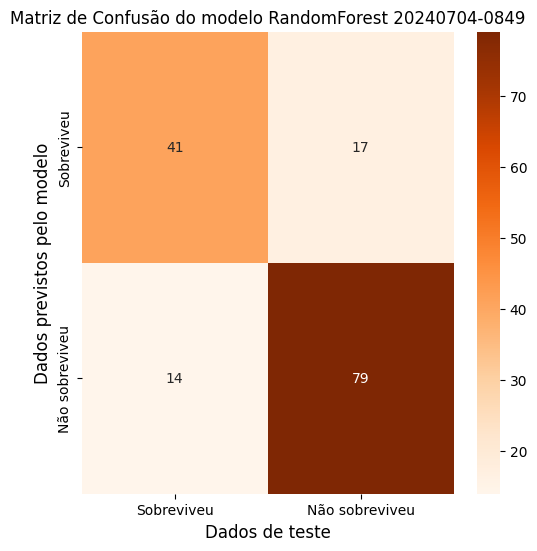

In [196]:
# O parâmetro 'labels' identifica as classificações dentro das variáveis, a primeira sendo a variável positiva e a segunda, a negativa
# Pela lógica, positiva aqui significa 'sobrevivente'.

conf_matrix = metrics.confusion_matrix(teste_y.Survived.values.astype('int'), ypred_skl_rf, labels=[1, 0])

# Plotagem da matriz
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix,
            annot = True,
            cmap = 'Oranges',
            xticklabels = ['Sobreviveu', 'Não sobreviveu'],
            yticklabels = ['Sobreviveu', 'Não sobreviveu'])
plt.title(f'Matriz de Confusão do modelo RandomForest {nome_modelo}', fontsize=12)
plt.xlabel('Dados de teste', fontsize=12)
plt.ylabel('Dados previstos pelo modelo', fontsize=12)
plt.show()

### Registro para consulta

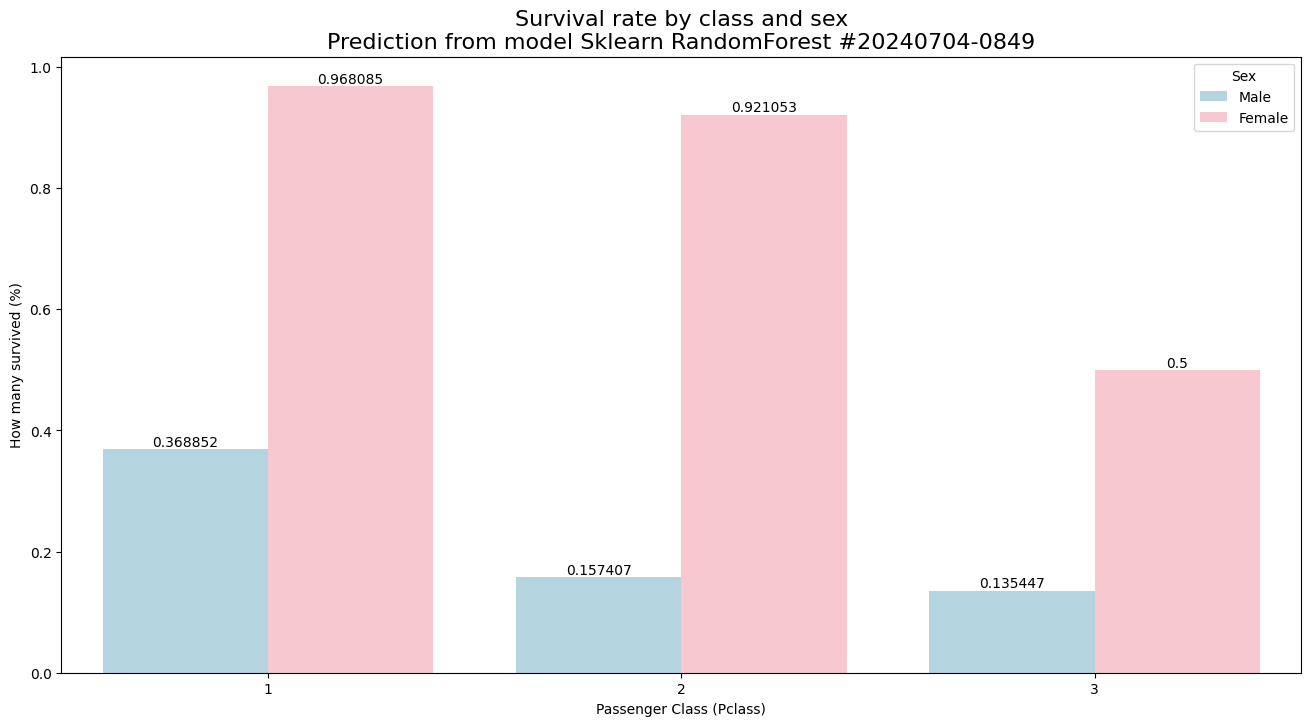

In [197]:
with open("./registros/registros_skl_rf.txt", "a") as registros:
    registros.write("########## INÍCIO DE REGISTRO - MODELO Sklearn RandomForest " + nome_modelo + " ##########\n")
    registros.write("\nInformações geradas em " + datetime.now().strftime("%d-%m-%Y") + " às " + datetime.now().strftime("%H:%M") + ".\n")
    warnings.filterwarnings("ignore") # inibe os avisos dessa seção, volta ao normal no fim

    # Impostação do resultado obtido
    mask = dados_skl_rf['origem'] == 'teste'
    dados_skl_rf.loc[mask, 'Survived'] = ypred_skl_rf_final.astype('int')

    # Dos dados de Treino
    registros.write('\n---===+++ Predicted and historical ranking comparison +++===---\n')
    registros.write('\nSurvived/perished relationship in *TRAINING* data:\n')

        # Máscaras
    mask1 = dados_skl_rf[(dados_skl_rf['Pclass'] == 1) & (dados_skl_rf['origem'] == 'treino')].index
    mask2 = dados_skl_rf[(dados_skl_rf['Pclass'] == 2) & (dados_skl_rf['origem'] == 'treino')].index
    mask3 = dados_skl_rf[(dados_skl_rf['Pclass'] == 3) & (dados_skl_rf['origem'] == 'treino')].index
    
        # Relação de sobreviventes ou não da 1a classe
    ms1 = (len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Male')])*100)
    md1 = (len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Male')])*100)
    fs1 = (len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Female')])*100)
    fd1 = (len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Female')])*100)

        # Relação de sobreviventes ou não da 2a classe
    ms2 = (len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Male')])*100)
    md2 = (len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Male')])*100)
    fs2 = (len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Female')])*100)
    fd2 = (len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Female')])*100)

        # Relação de sobreviventes ou não da 3a classe
    ms3 = (len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Male')])*100)
    md3 = (len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Male')])*100)
    fs3 = (len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Female')])*100)
    fd3 = (len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Female')])*100)

    registros.write(f'                     PClass1        PClass2        Pclass3\n')
    registros.write(f'Male/Survived...:  {ms1:0>9f}%     {ms2:0>9f}%     {ms3:0>9f}%\n')
    registros.write(f'Male/Perished...:  {md1:0>9f}%     {md2:0>9f}%     {md3:0>9f}%\n')
    registros.write(f'                        *              *              *\n')
    registros.write(f'Female/Survived.:  {fs1:0>9f}%     {fs2:0>9f}%     {fs3:0>9f}%\n')
    registros.write(f'Female/Perished.:  {fd1:0>9f}%     {fd2:0>9f}%     {fd3:0>9f}%\n')

    # Das previsões
    registros.write('\nSurvived/perished relationship in *PREDICTED* data:\n')

    mask1 = dados_skl_rf[(dados_skl_rf['Pclass'] == 1) & (dados_skl_rf['origem'] == 'teste')].index
    mask2 = dados_skl_rf[(dados_skl_rf['Pclass'] == 2) & (dados_skl_rf['origem'] == 'teste')].index
    mask3 = dados_skl_rf[(dados_skl_rf['Pclass'] == 3) & (dados_skl_rf['origem'] == 'teste')].index

        # Relação de sobreviventes ou não da 1a classe
    ms1 = (len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Male')])*100)
    md1 = (len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Male')])*100)
    fs1 = (len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Female')])*100)
    fd1 = (len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask1][(dados_skl_rf['Sex'] == 'Female')])*100)

        # Relação de sobreviventes ou não da 2a classe
    ms2 = (len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Male')])*100)
    md2 = (len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Male')])*100)
    fs2 = (len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Female')])*100)
    fd2 = (len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask2][(dados_skl_rf['Sex'] == 'Female')])*100)

        # Relação de sobreviventes ou não da 3a classe
    ms3 = (len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Male')])*100)
    md3 = (len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Male') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Male')])*100)
    fs3 = (len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 1)]) / len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Female')])*100)
    fd3 = (len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Female') & (dados_skl_rf['Survived'] == 0)]) / len(dados_skl_rf.loc[mask3][(dados_skl_rf['Sex'] == 'Female')])*100)


    registros.write(f'                     PClass1        PClass2        Pclass3\n')
    registros.write(f'Male/Survived...:  {ms1:0>9f}%     {ms2:0>9f}%     {ms3:0>9f}%\n')
    registros.write(f'Male/Perished...:  {md1:0>9f}%     {md2:0>9f}%     {md3:0>9f}%\n')
    registros.write(f'                        *              *              *\n')
    registros.write(f'Female/Survived.:  {fs1:0>9f}%     {fs2:0>9f}%     {fs3:0>9f}%\n')
    registros.write(f'Female/Perished.:  {fd1:0>9f}%     {fd2:0>9f}%     {fd3:0>9f}%\n')

    # Prints the predictions graph
    ext_graph = (".png")
    name_graph = ("previsoes_Sklearn_RandomForest_"+(nome_modelo + ext_graph))
    plt.figure(figsize =(16, 8))
    sns.color_palette("pastel")
    graph = sns.barplot(data=dados_skl_rf[dados_skl_rf['origem'] == 'treino'], x='Pclass', y='Survived', hue = 'Sex', hue_order = ['Male', 'Female'], palette = paleta, errorbar = None)
    graph.bar_label(graph.containers[0], fontsize=10)
    graph.bar_label(graph.containers[1], fontsize=10)
    plt.ylabel("How many survived (%)")
    plt.xlabel('Passenger Class (Pclass)')
    plt.title(f'Survival rate by class and sex\nPrediction from model Sklearn RandomForest #{nome_modelo}', fontsize = 16)
    fig = graph.get_figure()
    fig.savefig('./imagens/'+name_graph)

    registros.write("\nFeatures que foram utilizadas no modelo e que tiveram relevância no algoritmo:\n")
    importancias = pd.DataFrame(classif_skl_rf.feature_importances_, classif_skl_rf.feature_names_in_)
    importancias.reset_index(inplace = True)
    importancias.columns = ["variável", "importância"]
    registros.write(str(importancias[importancias['importância'] > 0].sort_values(by = "importância", ascending = False)))
    if discard_index.sum() > 0:
        registros.write("\n\nFeatures sem importância:"+ str(dados_treino.columns.values[discard_index]) + ".\n")
    else: registros.write("\n\nNão foram identificadas features sem importância.\n")

    registros.write(f'\nCoeficiente de Determinação R2: {score_skl_rf:.6f}\n')
    registros.write(f'Score de validação cruzada: {cv_scores_skl_rf.mean():.6f}\n\n')

    if dados_skl_rf.Fare.max() > 300: registros.write("Outliers em 'Fare' identificados.\n")
    else: registros.write("Não foram identificados outliers (somente 'Fare' é passível de ter outliers).\n")


    registros.write("\nParâmetros do modelo:\n")
    registros.write(str(classif_skl_rf.get_params()))
    registros.write("\n\n=======================================================================\n\n\n")

# Visualização comparativa XGBoost, CatBoost, LightGBM, RandomForest

In [198]:
print(f'Relação dos scores de Coeficiente de Determinação R2:')
print(f'Score R2 XGBoost.......: {round(score_xgb_r2, 6)}')
print(f'Score R2 CatBoost......: {round(score_cat_r2, 6)}')
print(f'Score R2 LightGBM......: {round(score_lgbm_r2, 6)}')
print(f'Score R2 RandomForest..: {round(score_skl_rf, 6)}\n')

print(f'Relação dos scores de Cross-Validation 5-fold (média):')
print(f'Score CV XGBoost.......: {round(cv_scores_xgb_treino.mean(), 6)}')
print(f'Score CV CatBoost......: {round(cv_scores_cat.mean(), 6)}')
print(f'Score CV LightGBM......: {round(cv_scores_lgbm.mean(), 6)}')
print(f'Score CV RandomForest..: {round(cv_scores_skl_rf.mean(), 6)}\n\n')

Relação dos scores de Coeficiente de Determinação R2:
Score R2 XGBoost.......: 0.24416
Score R2 CatBoost......: 0.188172
Score R2 LightGBM......: 0.160178
Score R2 RandomForest..: 0.132184

Relação dos scores de Cross-Validation 5-fold (média):
Score CV XGBoost.......: 0.836143
Score CV CatBoost......: 0.81792
Score CV LightGBM......: 0.832837
Score CV RandomForest..: 0.826171




# Ensemble

In [207]:
# Carregamento dos arquivos
print('Carregando os arquivos para o ensemble...')
catboost = pd.read_csv('./resultados/ensemble/resultado_CatBoostClassifier_20240704-0848.csv', index_col = False)
#xgb = pd.read_csv('./resultados/ensemble/resultado_XGBClassifier_20240630-1749.csv', index_col = False)
xgb = pd.read_csv('./resultados/ensemble/resultado_XGBClassifier_20240704-0847.csv', index_col = False)
lightgbm = pd.read_csv('./resultados/ensemble/resultado_LightGBMClassifier_20240704-0848.csv', index_col = False)
randomforest = pd.read_csv('./resultados/ensemble/resultado_Sklearn_RandomForest_20240704-0849.csv', index_col = False)

# Registro do nome do ensemble
nome_ensemble = datetime.now().strftime("%Y%m%d-%H%M")

# Cálculo do ensemble, com prioridade para a previsão individual de maior acerto
print('Realizando cálculo dos valores para ensemble...')
ensemble = (catboost + randomforest + xgb + lightgbm)/4

# Ajuste da classificação binária
print('Ajuste da classificação binária...\n')
for i in range(len(ensemble.Survived)):
#    if (ensemble.Survived.loc[i] == 1.05) | (ensemble.Survived.loc[i] == 0.55): ensemble.Survived.loc[i] = 1
    if ensemble.loc[i, 'Survived'] > 0.5: ensemble.loc[i, 'Survived'] = 1
    elif ensemble.loc[i, 'Survived'] <= 0.5: ensemble.loc[i, 'Survived'] = 0

# Verificação sobre binariedade do ensemble
print('Verificação da binariedade do ensemble:')
print(ensemble.Survived.value_counts())

Carregando os arquivos para o ensemble...
Realizando cálculo dos valores para ensemble...
Ajuste da classificação binária...

Verificação da binariedade do ensemble:
Survived
0.0    269
1.0    149
Name: count, dtype: int64


In [208]:
# Se tudo estiver correto, segue-se com a geração do arquivo para submissão
print(f'Ensemble em uso possui registro {nome_ensemble}.')
print("Compilando nome de arquivo ensemble para submissão...")
# Composição do nome a ser salvo
ext_final = (".csv")
save_final = ("resultado_ensemble_"+(nome_ensemble + ext_final))

print("Gerando arquivo de submissão com nome " + save_final)
# Leitura do arquivo de submisão, registro dos dados obtidos e regravação do arquivo com estes dados
submissao = pd.read_csv("./dados/gender_submission.csv")
submissao["Survived"] = ensemble.Survived.astype('int')
submissao.to_csv("./resultados/"+save_final, index=False)

print("\nProcedimento realizado com sucesso. O arquivo em questão encontra-se na pasta de destino ('./resultados/').")

Ensemble em uso possui registro 20240704-0902.
Compilando nome de arquivo ensemble para submissão...
Gerando arquivo de submissão com nome resultado_ensemble_20240704-0902.csv

Procedimento realizado com sucesso. O arquivo em questão encontra-se na pasta de destino ('./resultados/').
